(mmm_allocation_assessment)=
# Budget Allocation Risk Assessment with PyMC-Marketing

The focus of this notebook is on assessing the risk associated with different budget allocations across various marketing channels. By quantifying the potential variability in outcomes, and teaching how to generate a budget allocation that is optimal under a risk tolerance criterion, this notebook provides valuable insights for making informed budget allocation decisions.

## Prerequisite Knowledge
The notebook assumes the reader has knowledge of the essential functionalities of PyMC-Marketing. If one is unfamiliar, the ["MMM Example Notebook"](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html) serves as an excellent starting point, offering a comprehensive introduction to media mix models in this context.

## What to Anticipate
Upon completing this notebook, readers should get a comprehensive understanding of how to assess the risk associated with different budget allocations, and how to generate a budget allocation that is optimal under a risk tolerance criterion.

## Basic Setup
Like previous notebooks in PyMC-Marketing, this relies on a specific library set. Here are the requisite imports necessary for executing the provided code snippets subsequently.


In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pymc_marketing.mmm import MMM

warnings.filterwarnings("ignore")

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The expectation is that a model has already been trained using the functionalities provided in prior versions of the PyMC-Marketing library. Thus, the data generation and training processes will be replicated in a different notebook. Those unfamiliar with these procedures are advised to refer to the ["MMM Example Notebook."](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html)

## Loading a Pre-Trained Model
To utilize a saved model, load it into a new instance of the MMM class using the load method below.

In [2]:
mmm = MMM.load("model.nc")

## Defining the Budget Allocation Problem
As in previous notebooks, we need define the budget allocation problem. Basically, we must define how long our budget allocation will be, and how much we can spend per time unit. Our model is trained on weekly data, so we will follow the same time granularity.

On this example, we are trying to allocate a budget across two channels over 8 weeks, with a weekly budget of 5M. Meaning, the total budget to allocate is 40M.

In [3]:
num_periods = (
    8  # Number of time periods to allocate the budget (weeks for this example)
)
time_unit_budget = 5  # Imagine is 5K or 5M (per week in this case)

# Define your channels
channels = ["x1", "x2"]

print(f"Total budget to allocate: {num_periods * time_unit_budget}M")

Total budget to allocate: 40M


The usual approach is to allocate the budget to maximize the response. We can use the `allocate_budget_to_maximize_response` method to do so, here we will compute the response given several budget combinations, and we'll prefer the one that maximizes the response. It's important to note that this example doesn't use any bounds, or constraints, so the optimizer will seek to use the entire budget.

Sampling: [y]


Output()

Budget allocation: {'x1': 2.8392426424096517, 'x2': 2.1607573575903483}
Total Allocated Budget: 5.0M


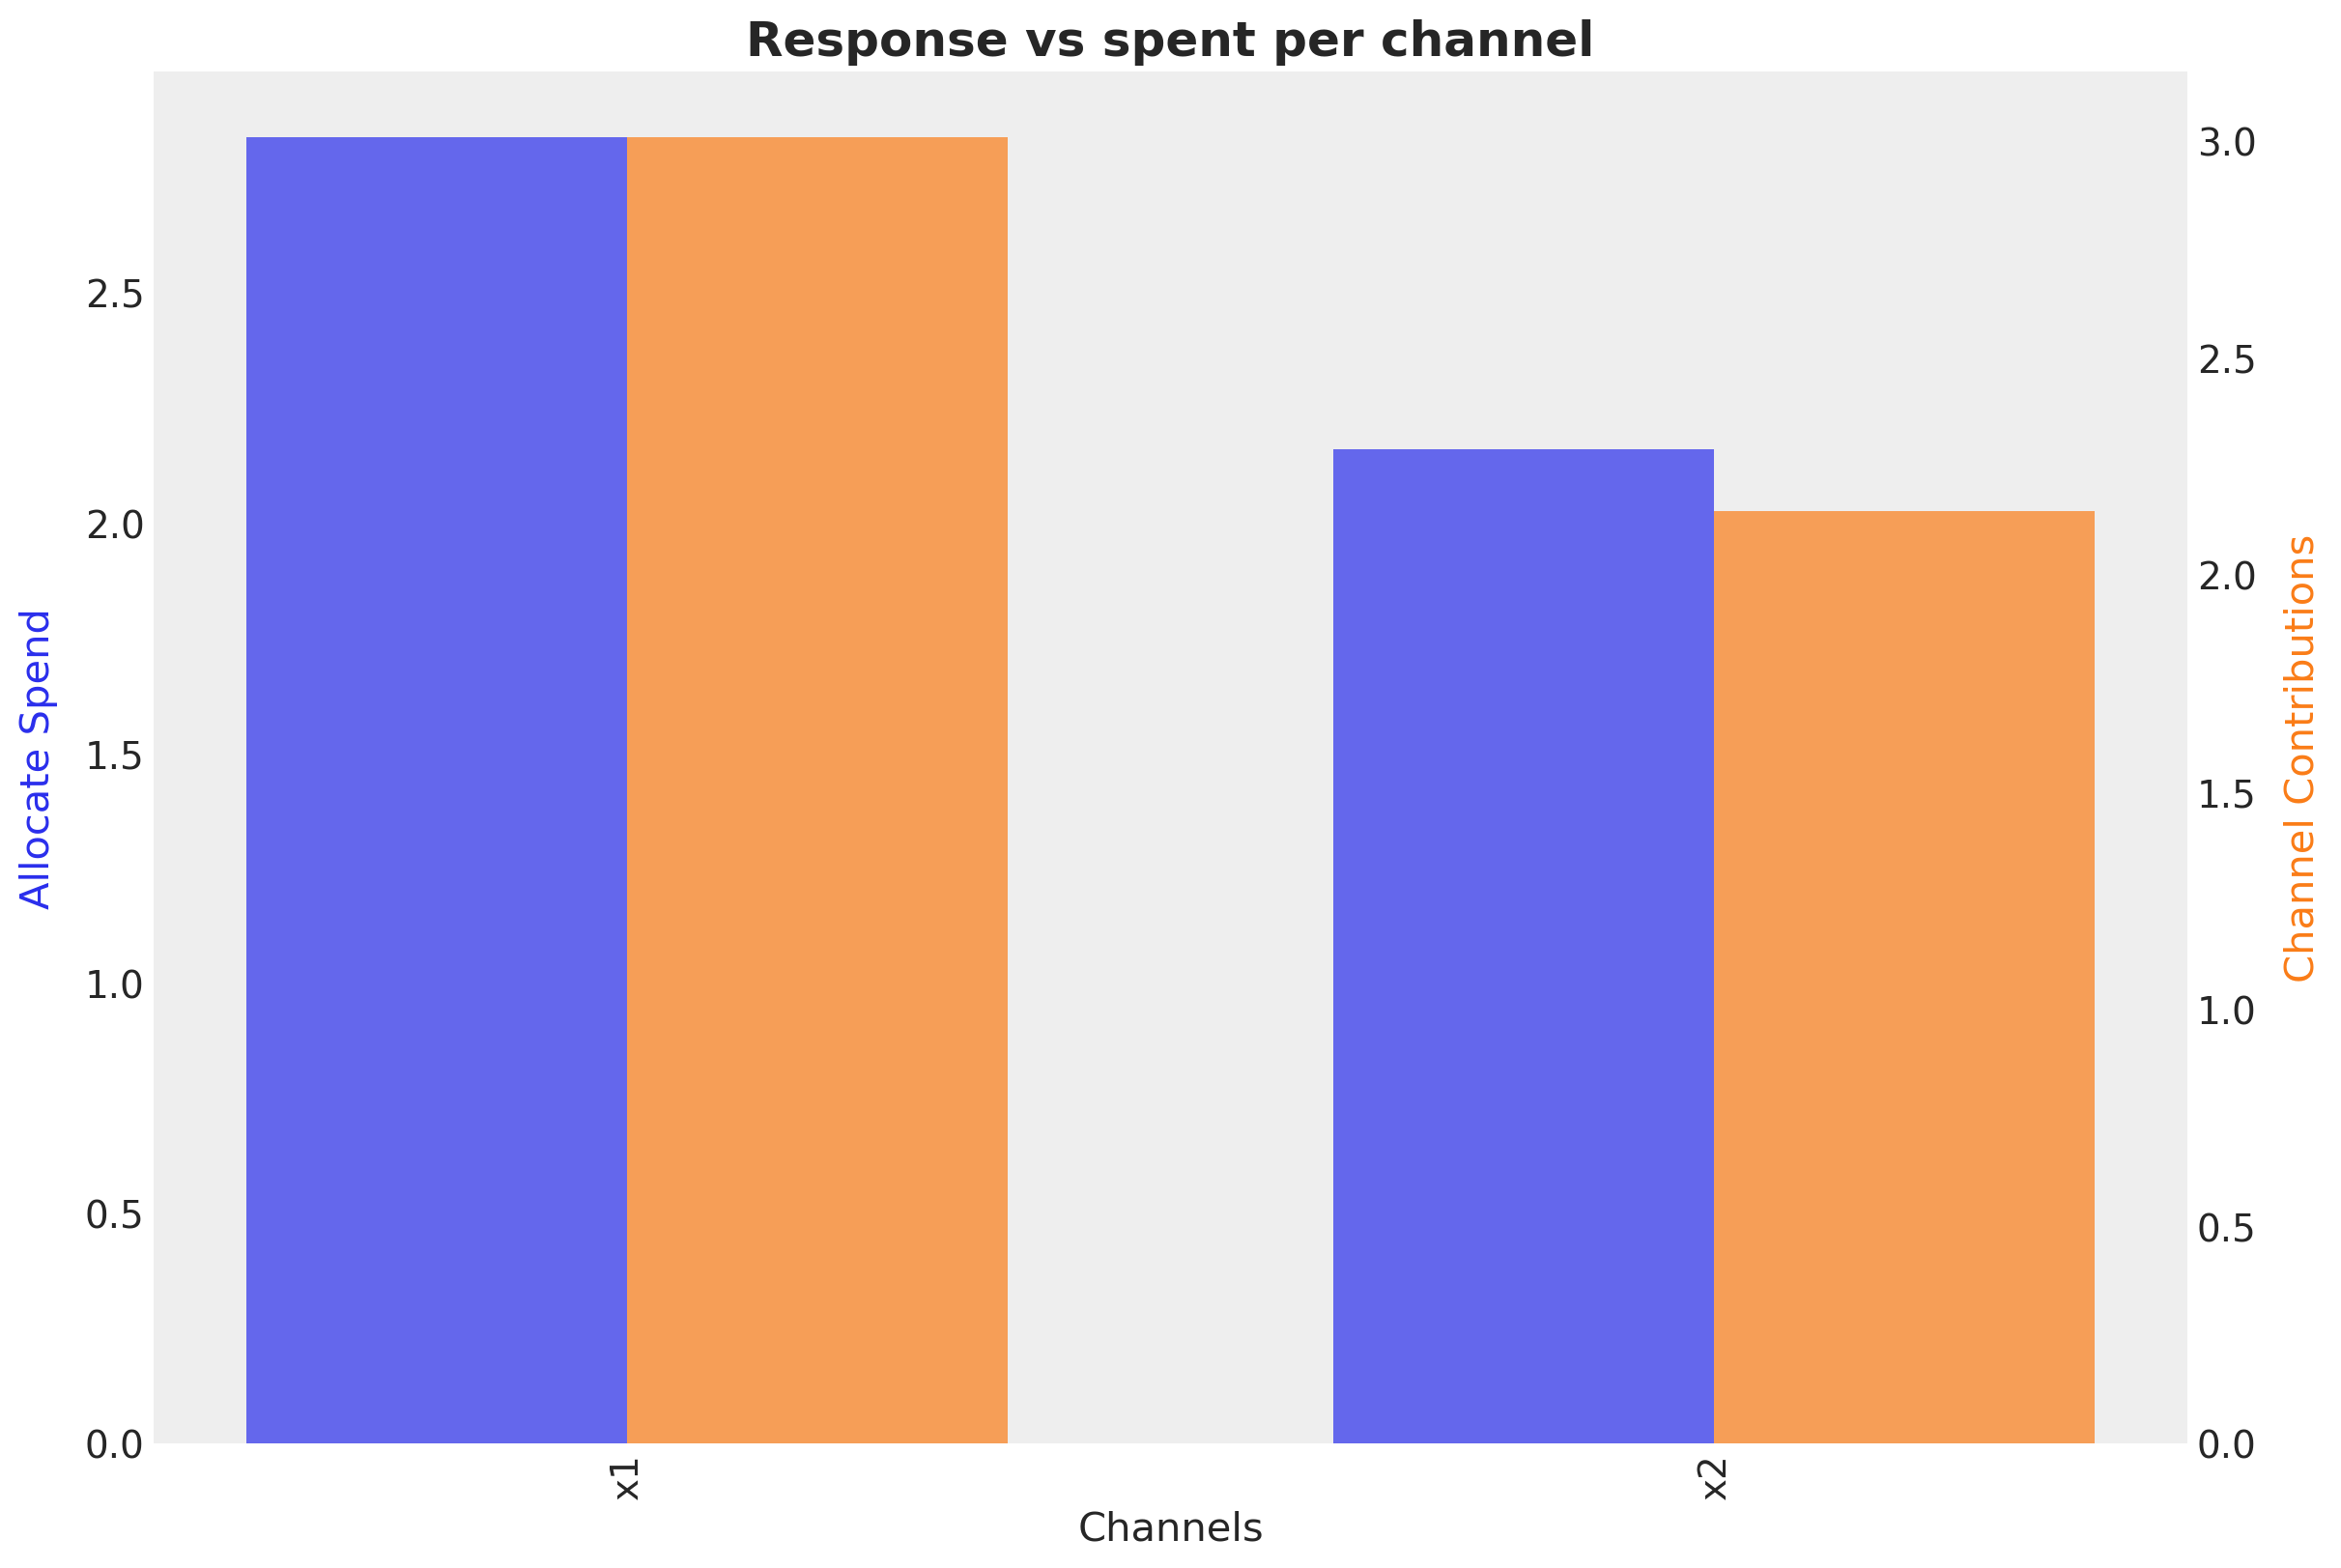

In [4]:
response = mmm.allocate_budget_to_maximize_response(
    budget=time_unit_budget,
    num_periods=num_periods,
    time_granularity="weekly",
)

print(f"Budget allocation: {mmm.optimal_allocation_dict}")
print(f"Total Allocated Budget: {np.sum(list(mmm.optimal_allocation_dict.values()))}M")

fig, ax = mmm.plot_budget_allocation(samples=response, figsize=(12, 8))
ax.set_title("Response vs spent per channel", fontsize=18, fontweight="bold");

We can see that the optimizer is allocating the budget almost evenly between the two channels. $X1$ has an allocation of 2.8M, and $X2$ has an allocation of 2.1M.

## Risk Assessment Introduction
The `budget_optimizer` module contains several risk assessment criteria that can be used to evaluate the risk associated with different budget allocations. Each of these criteria is a statistical method from the class `RiskAssessment`.

You can use the `RiskAssessment` class to compute the risk associated with different budget allocations. If you want to use a custom risk assessment criterion, you can create your own function and pass it to the `allocate_budget_to_maximize_response` method if needed. Later on, we will see how to create your own risk assessment criterion.

In [5]:
from pymc_marketing.mmm.budget_optimizer import RiskAssessment

## Optimizing Budget Allocation with Value at Risk (VaR)
In this section, we aim to optimize our marketing budget allocation while taking risk into account. Specifically, we're using the Value at Risk (VaR) as our objective function to ensure that our budget plan minimizes potential losses within a certain confidence level.

### What's Happening Here?
We call mmm.allocate_budget_to_maximize_response to determine the optimal allocation of our marketing budget across different channels over the specified time periods, just as we did in the previous section.

The parameters are the same as in the previous section, with the addition of the `objective_function` and `objective_function_kwargs` parameters. 
In this case:
- `objective_function`: We set this to RiskAssessment.value_at_risk, which means we're using VaR as our optimization criterion.
- `objective_function_kwargs`: We pass {"confidence_level": 0.95} to specify that we're focusing on the 95% confidence level for VaR.

Value at Risk is a statistical technique used to measure the risk of loss on a portfolio or investment. In our marketing context, it helps us understand the worst expected loss over a specific budget allocation at a given confidence level.

Imagine planning a marketing campaign where you want to ensure that your promotional activities do not result in losses beyond a certain threshold. Minimizing VaR is like setting a protective barrier, ensuring that there's only a 5% chance that your losses will exceed this barrier. It's akin to choosing a route for your campaign that avoids high-risk areas, focusing on safer bets.

In [6]:
RiskAssessment.value_at_risk?

Signature:
RiskAssessment.value_at_risk(
    samples: numpy.ndarray,
    confidence_level: float = 0.95,
) -> float
Docstring:
Calculate the Value at Risk (VaR) at a specified confidence level.

VaR estimates the potential loss in value of an asset or portfolio over a defined period
for a given confidence interval. It is a standard measure used in risk management to
assess the risk of loss on a specific portfolio of financial assets.

The Value at Risk (VaR) is calculated as:

    .. math::
        VaR = \mu - Q_{(1 - \alpha)}

where:
    - :math:`\mu` is the mean of the sample returns.
    - :math:`Q_{(1 - \alpha)}` is the quantile at the specified confidence level.

Parameters
----------
samples : np.ndarray
    Array of sample returns or losses.
confidence_level : float, optional
    Confidence level for VaR (default is 0.95).

Returns
-------
float
    The VaR value at the specified confidence level.

Raises
------
ValueError
    If confidence_level is not between 0 and 1.

Referen

Sampling: [y]


Output()

Budget allocation: {'x1': 3.315631043157882, 'x2': 1.6843689568421185}
Total Allocated Budget: 5.0M


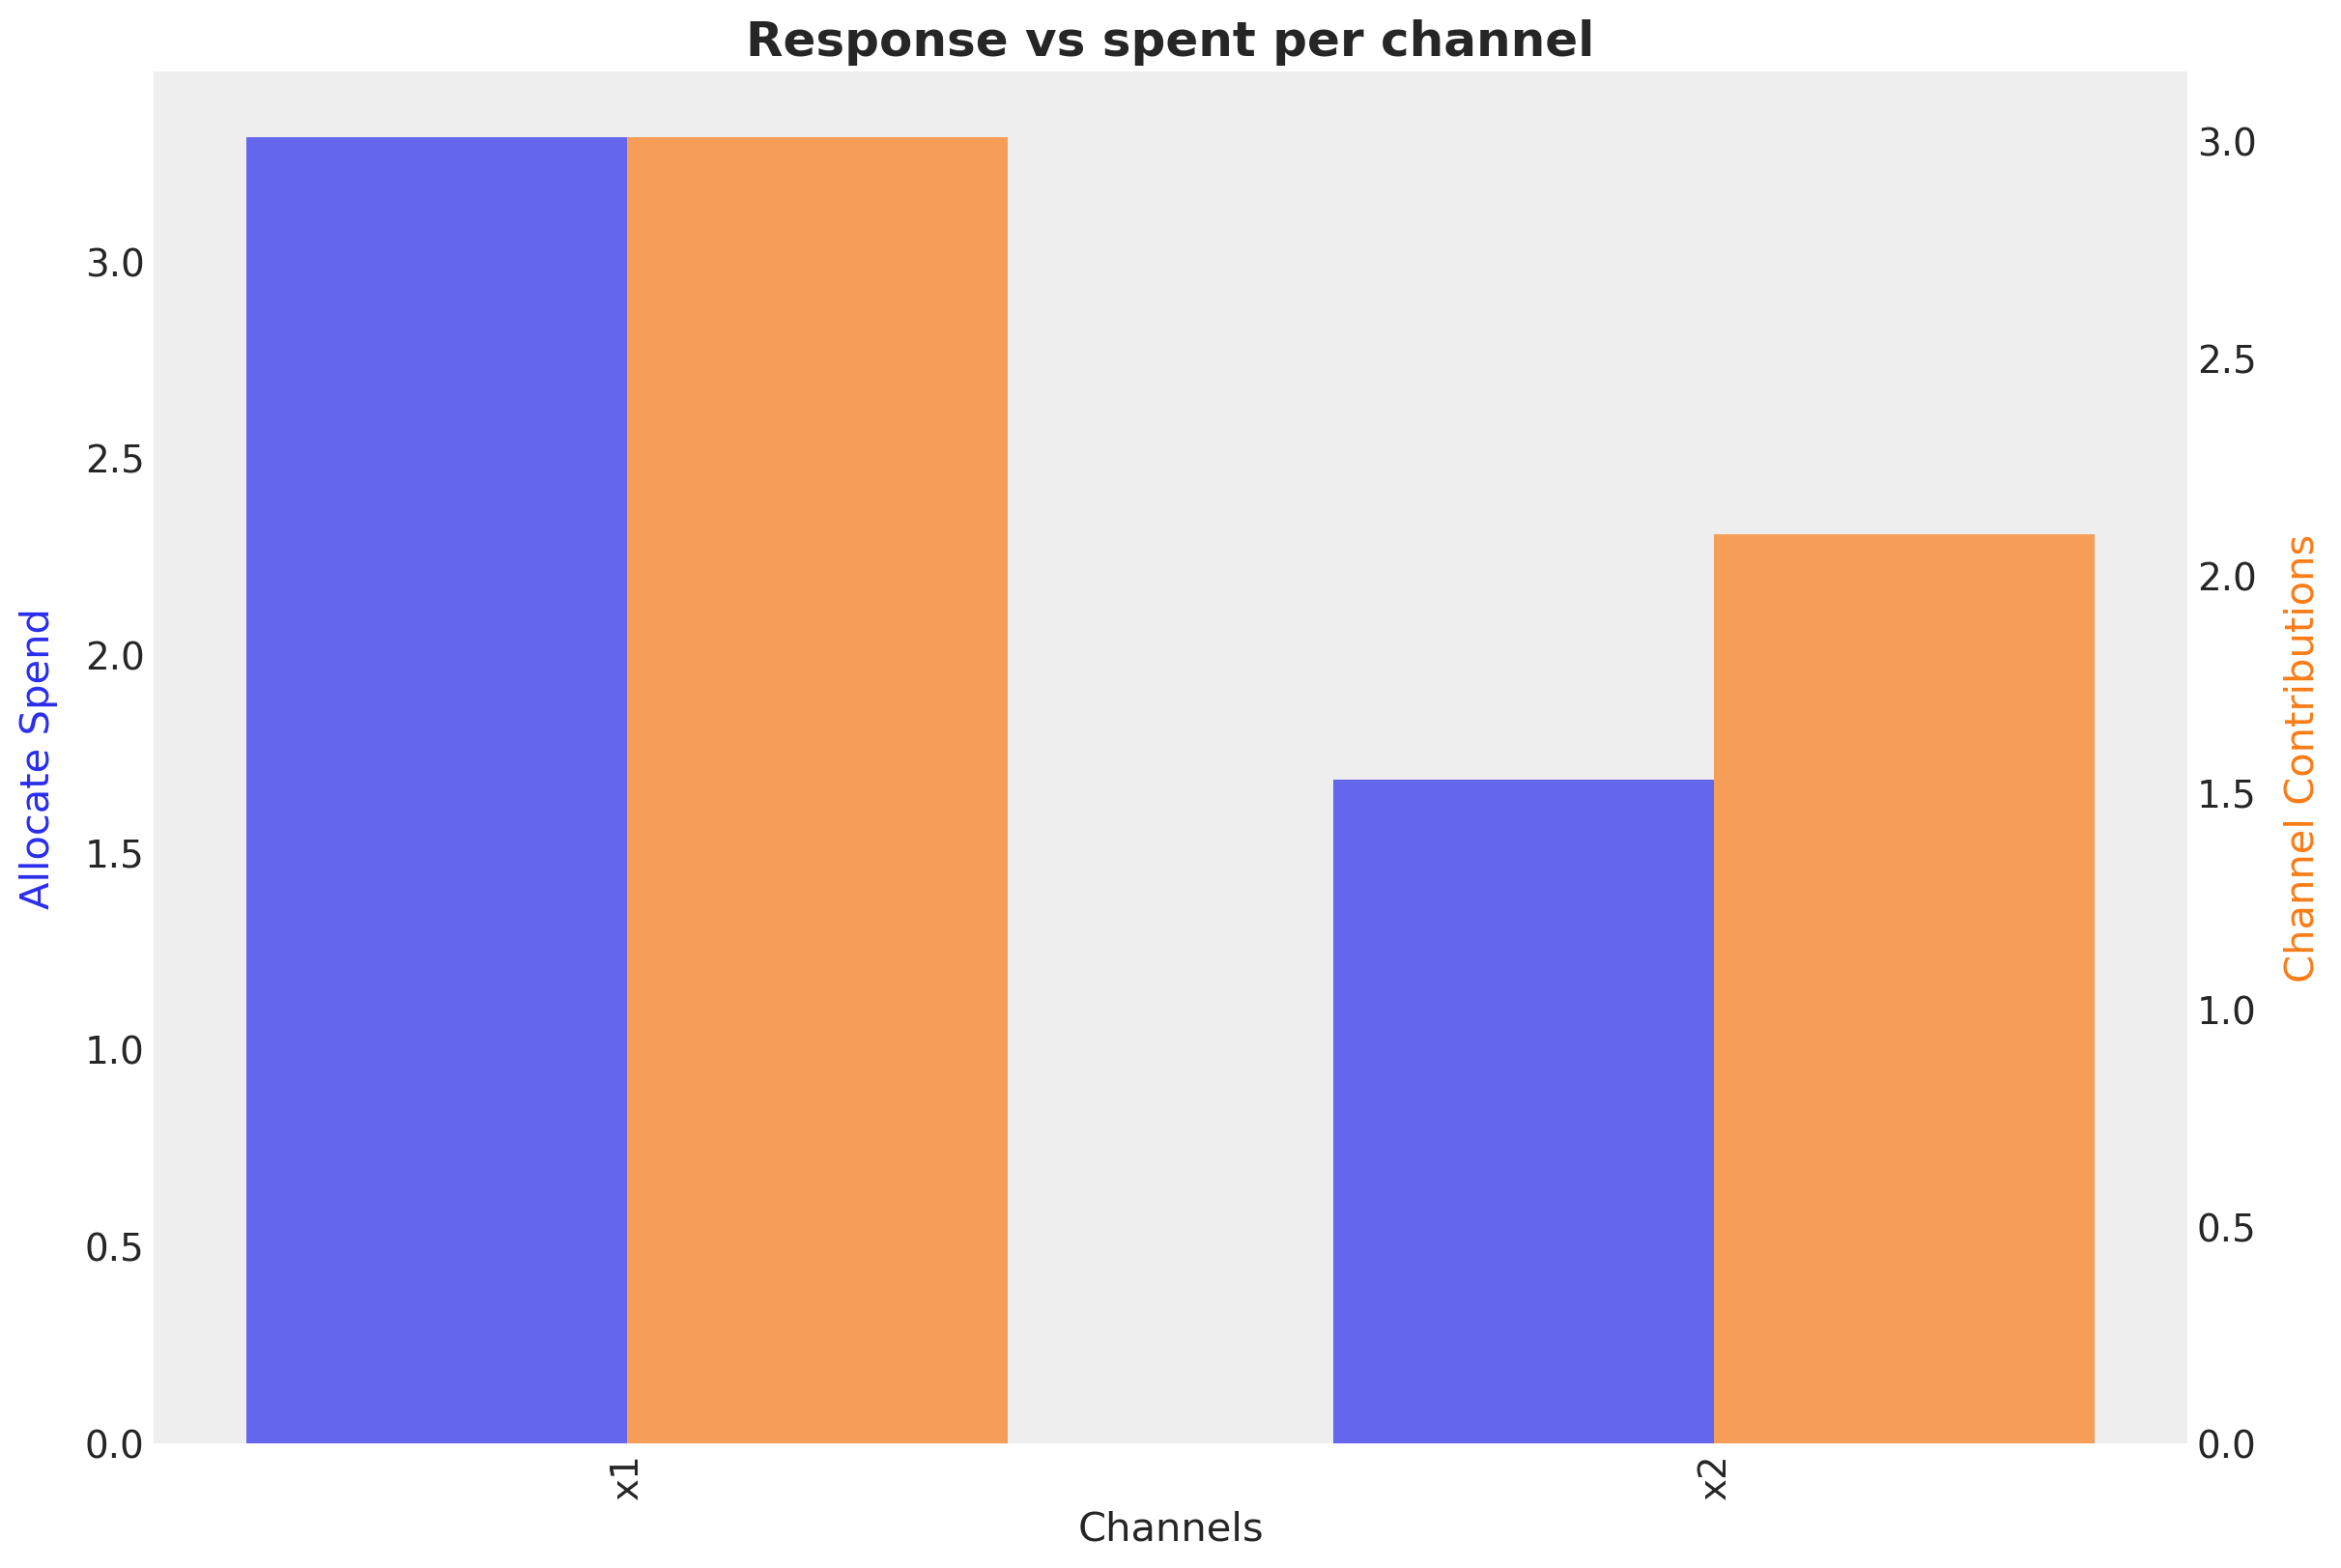

In [7]:
response_considering_risk = mmm.allocate_budget_to_maximize_response(
    budget=time_unit_budget,
    num_periods=num_periods,
    time_granularity="weekly",
    objective_function=RiskAssessment.value_at_risk,
    objective_function_kwargs={"confidence_level": 0.95},
)

print(f"Budget allocation: {mmm.optimal_allocation_dict}")
print(f"Total Allocated Budget: {np.sum(list(mmm.optimal_allocation_dict.values()))}M")

fig, ax = mmm.plot_budget_allocation(samples=response_considering_risk, figsize=(12, 8))
ax.set_title("Response vs spent per channel", fontsize=18, fontweight="bold");

This allocation is the one that minimizes the potential risk. Basically, we are saying that we are ok with a 5% chance that our losses will exceed the VaR. The result is that we are allocating in a way to reward narrow posterior with small tails, in other words, has less extreme values. We can see this in the response distribution plot.

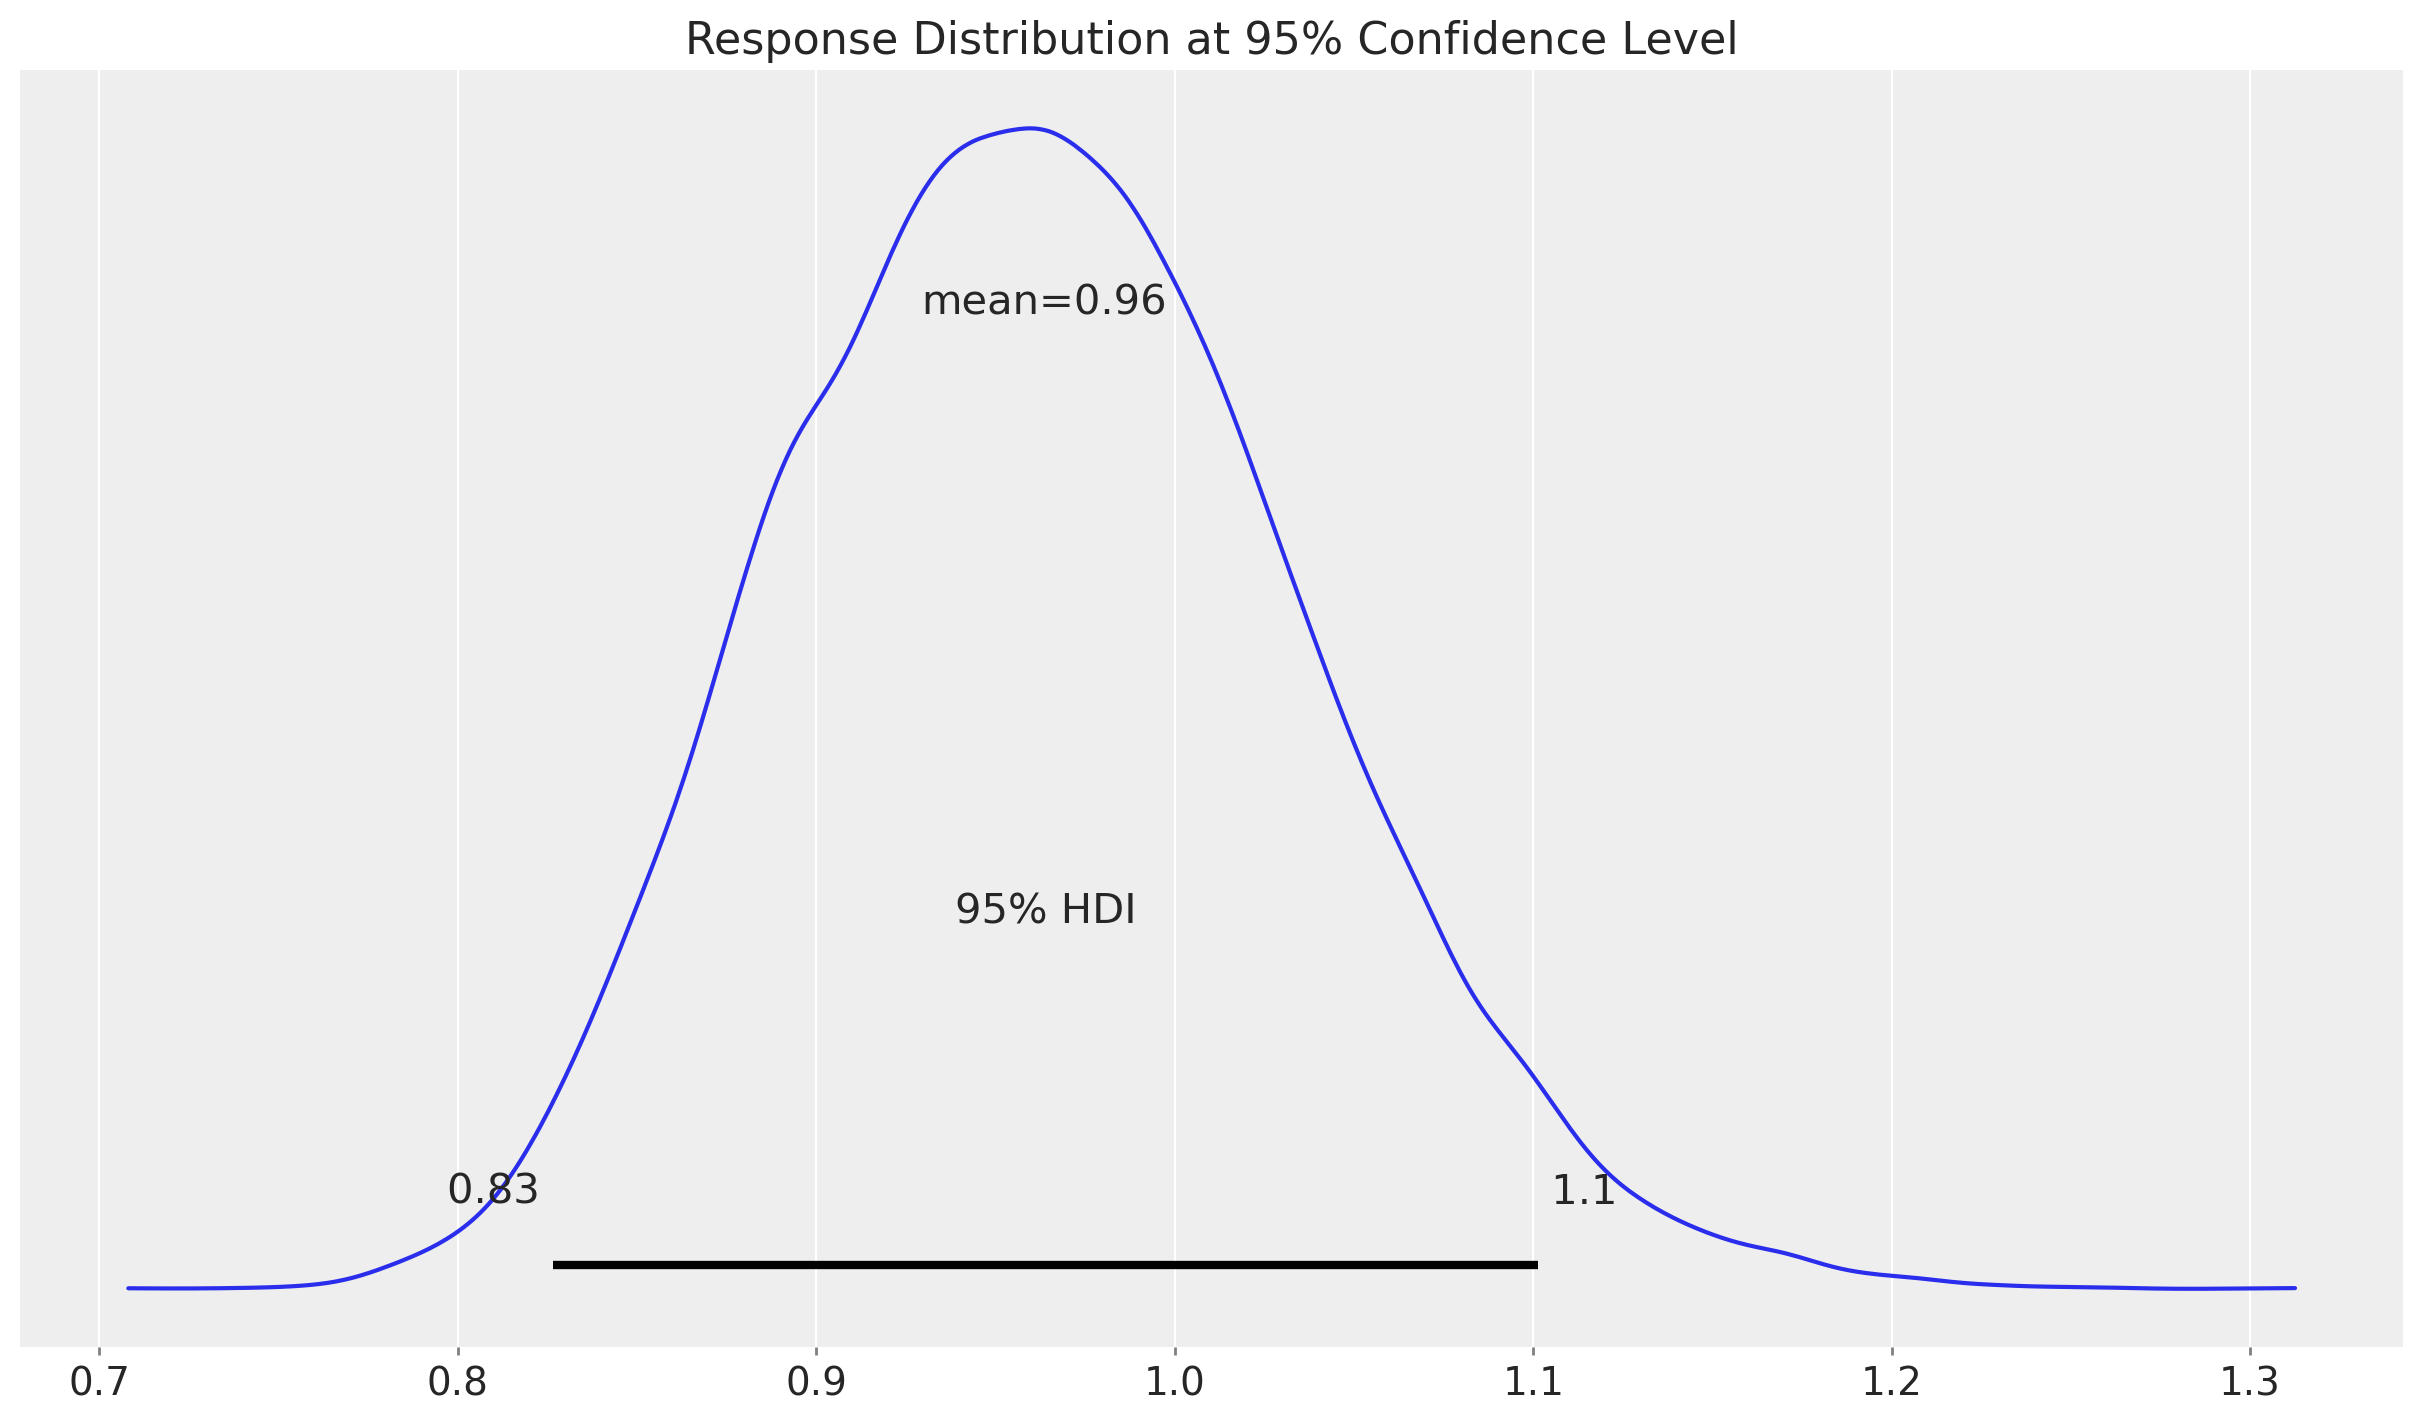

In [8]:
# Plot the response distribution by Arviz
az.plot_posterior(response_considering_risk.y.values.flatten(), hdi_prob=0.95)
plt.title("Response Distribution at 95% Confidence Level");

This makes a lot of sense, $X1$ has a response with less uncertainty, and $X2$ has a response with more uncertainty. Thats why the optimizer is allocating more budget to $X1$, becuase it represents a safer bet.

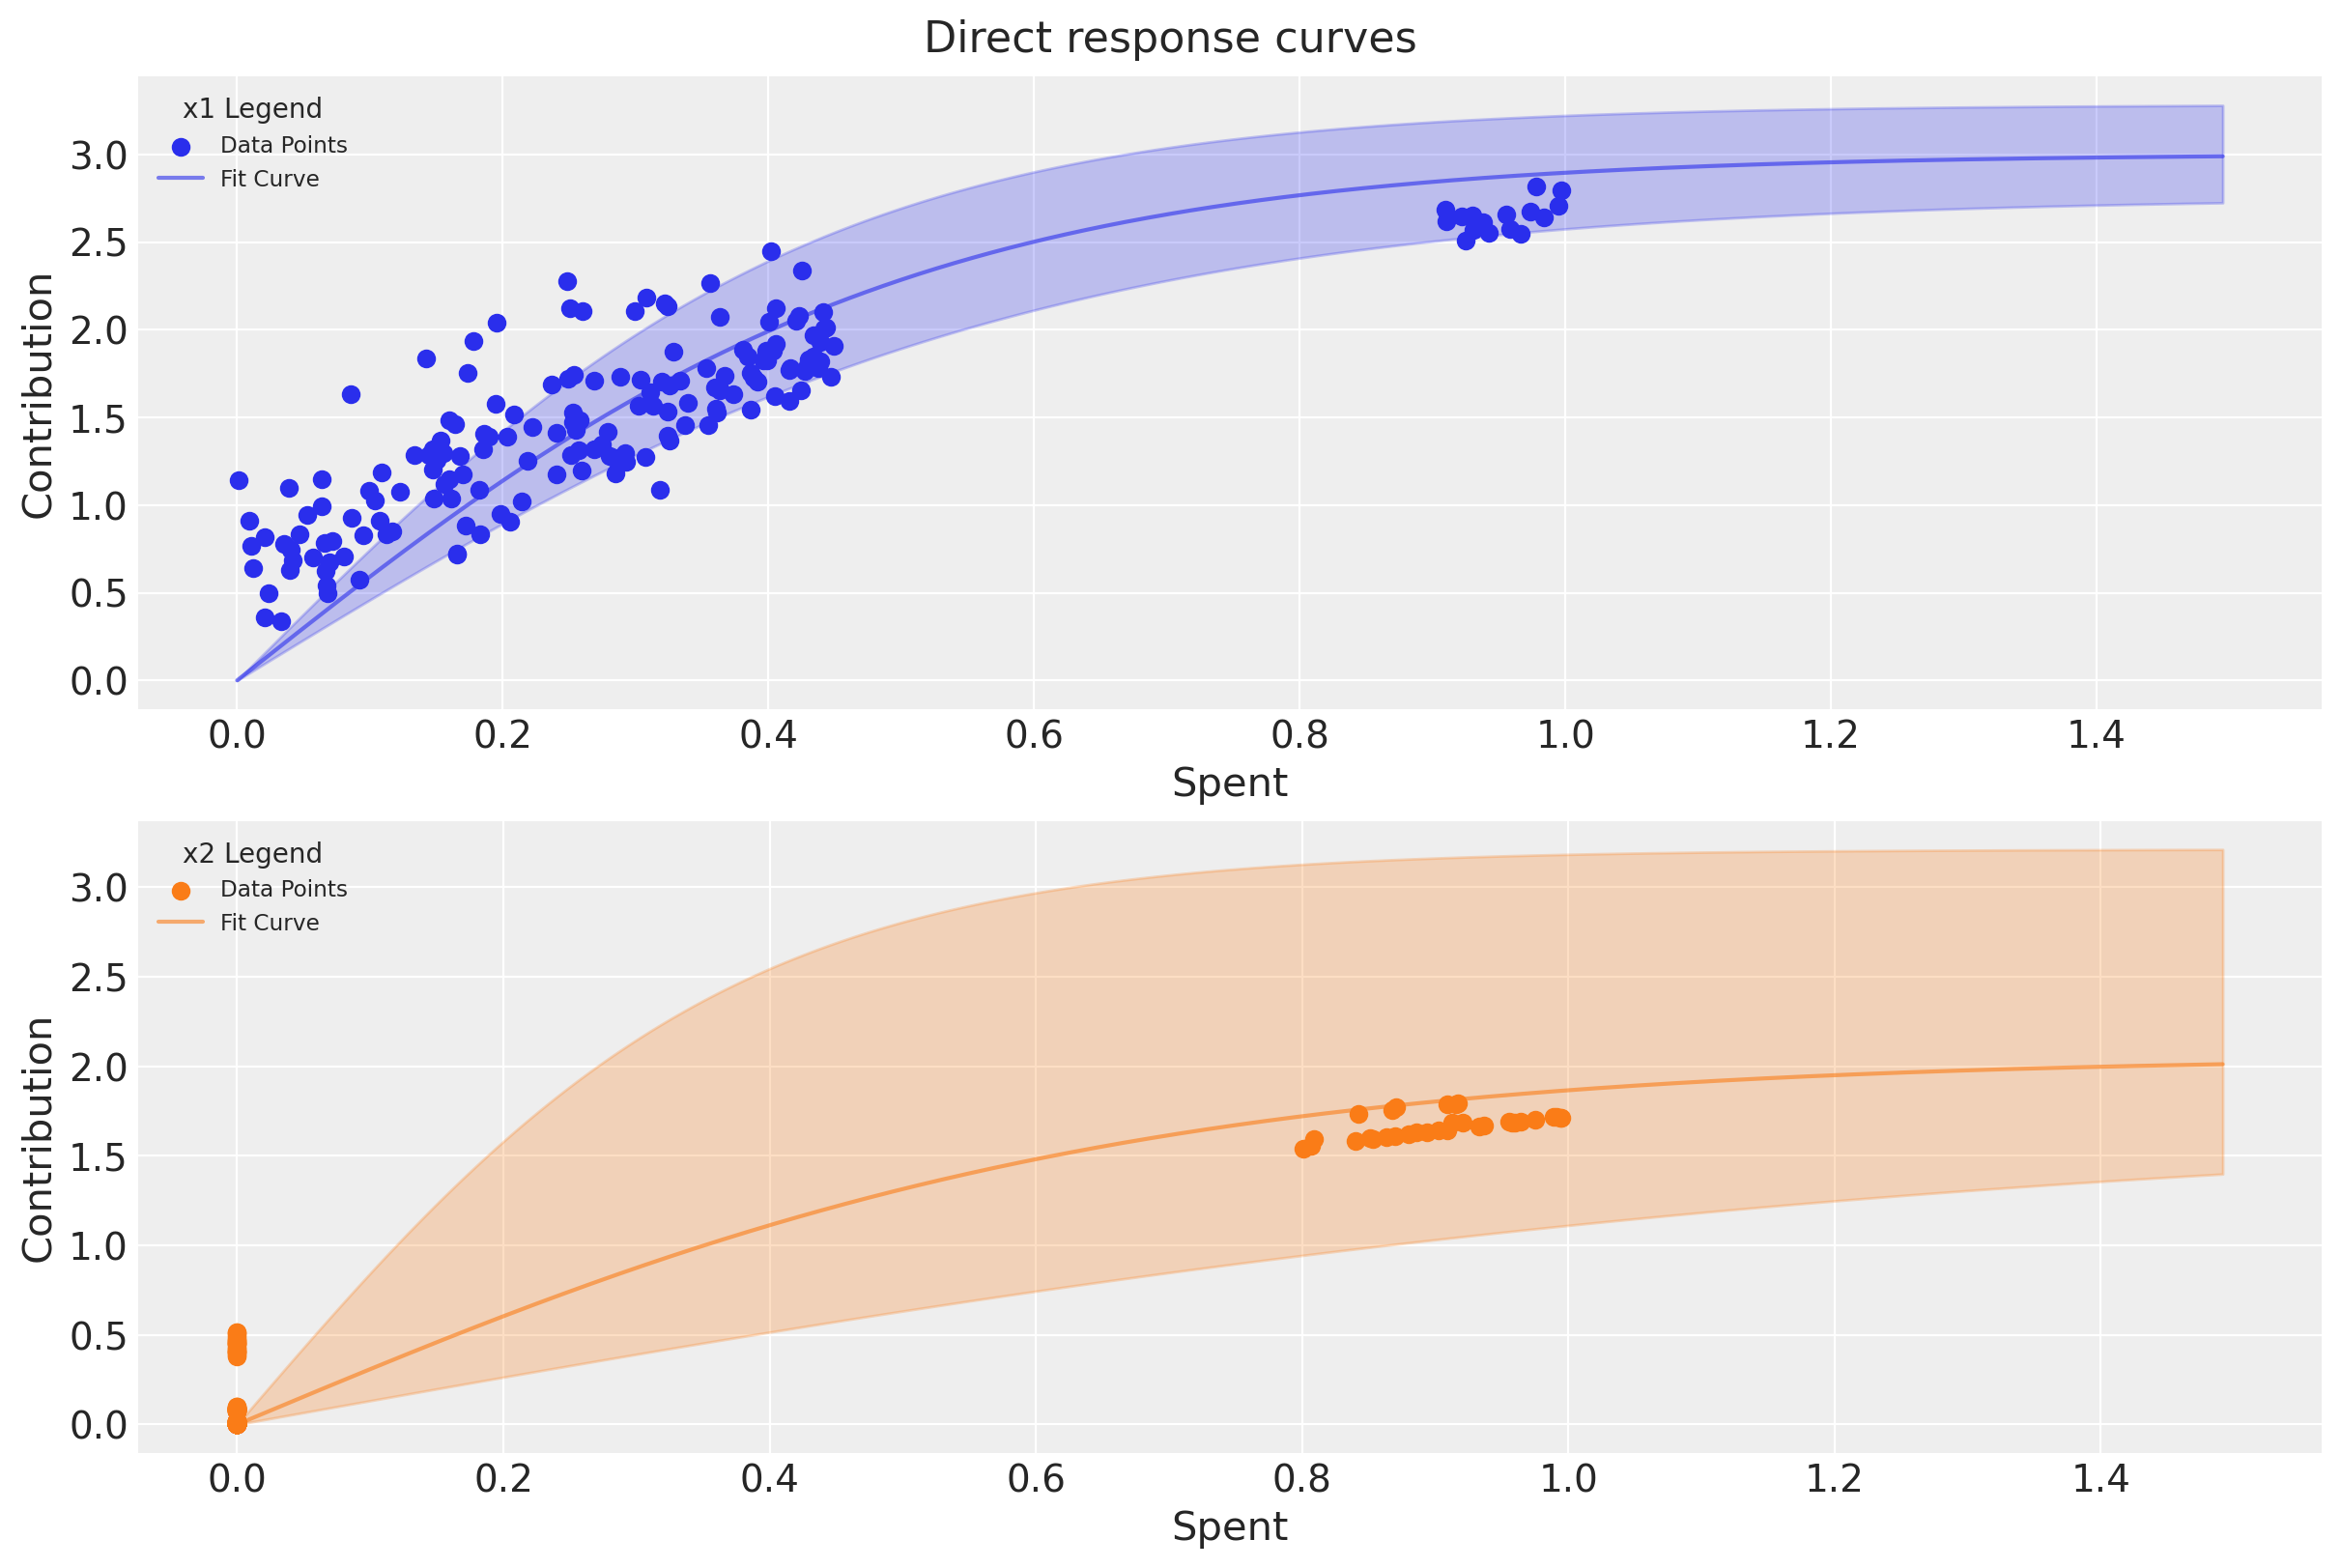

In [27]:
mmm.plot_direct_contribution_curves(show_fit=True, xlim_max=1.5);

We can exhibit this behavior on a more evident way; if we want to maximize the value at risk, we should get the opposite scenario. The optimizer will seek to get the largest possible distributions, meaning, the ones with biggest tails and extreme values. Lets see this in action just to validate the reasoning.

Sampling: [y]


Output()

Budget allocation: {'x1': 0.0, 'x2': 5.0}
Total Allocated Budget: 5.0M


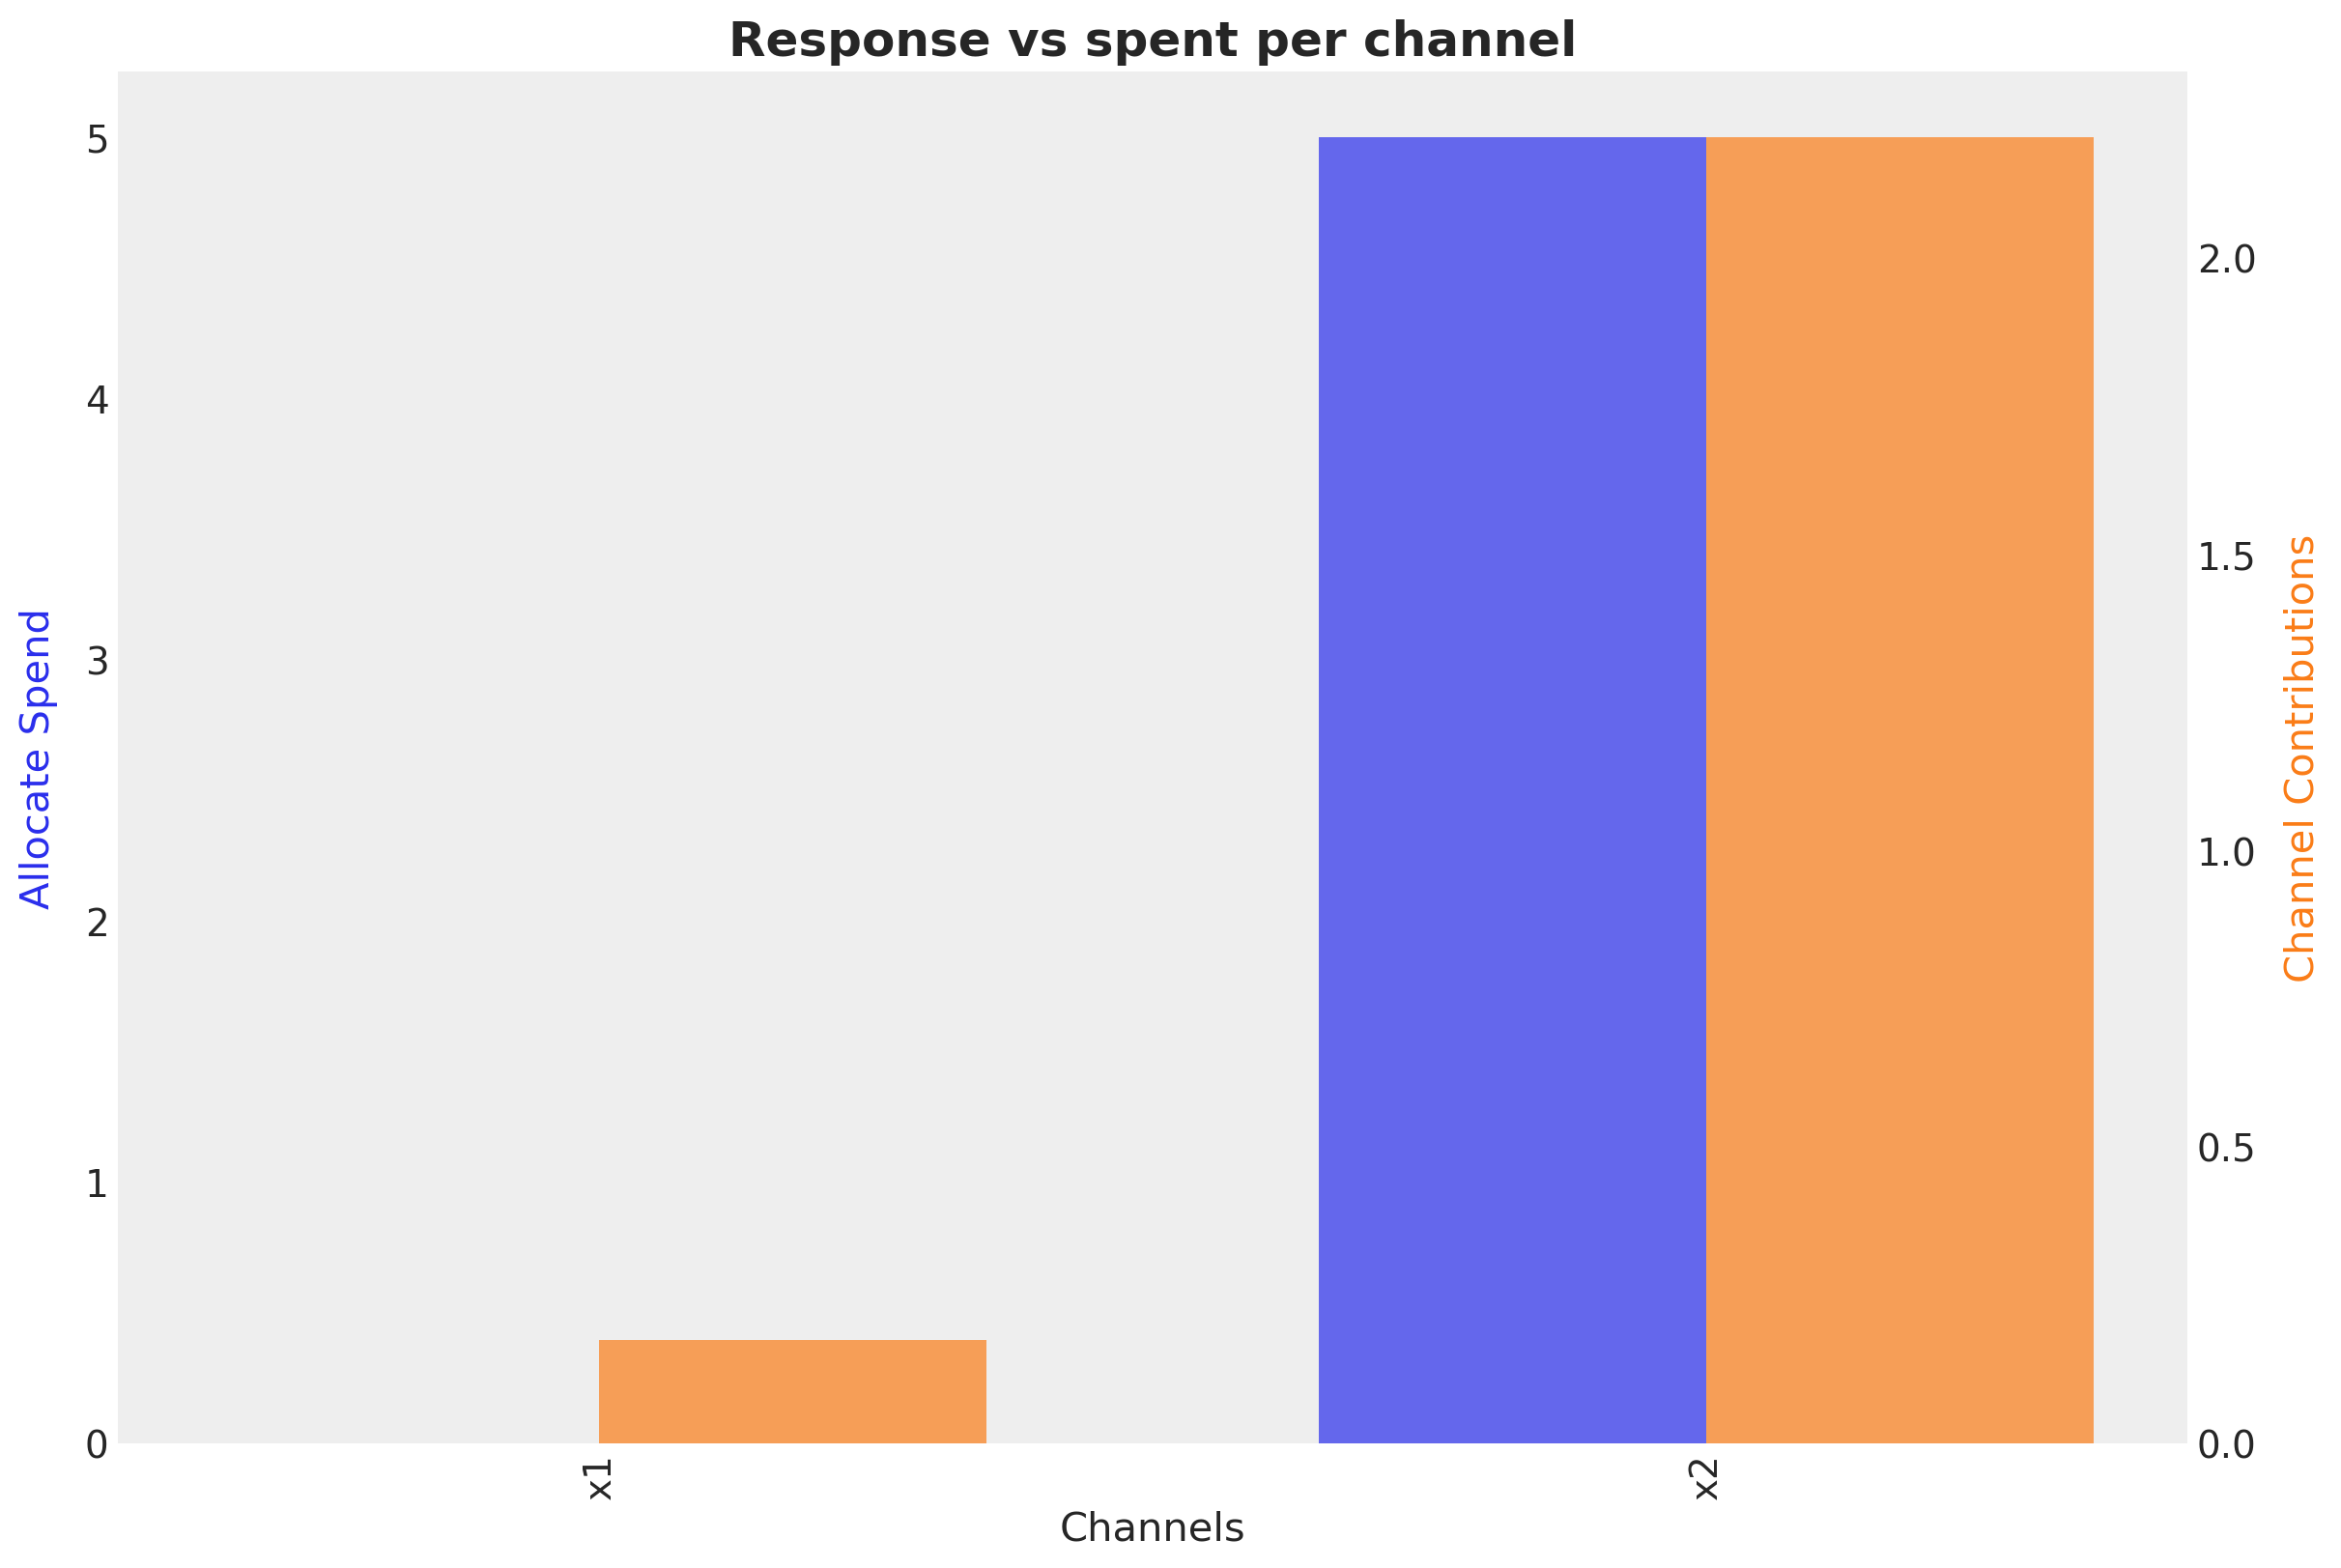

In [9]:
response_considering_risk = mmm.allocate_budget_to_maximize_response(
    budget=time_unit_budget,
    num_periods=num_periods,
    time_granularity="weekly",
    objective_function=lambda samples: -RiskAssessment.value_at_risk(samples, confidence_level=0.95),
)

print(f"Budget allocation: {mmm.optimal_allocation_dict}")
print(f"Total Allocated Budget: {np.sum(list(mmm.optimal_allocation_dict.values()))}M")

fig, ax = mmm.plot_budget_allocation(samples=response_considering_risk, figsize=(12, 8))
ax.set_title("Response vs spent per channel", fontsize=18, fontweight="bold");

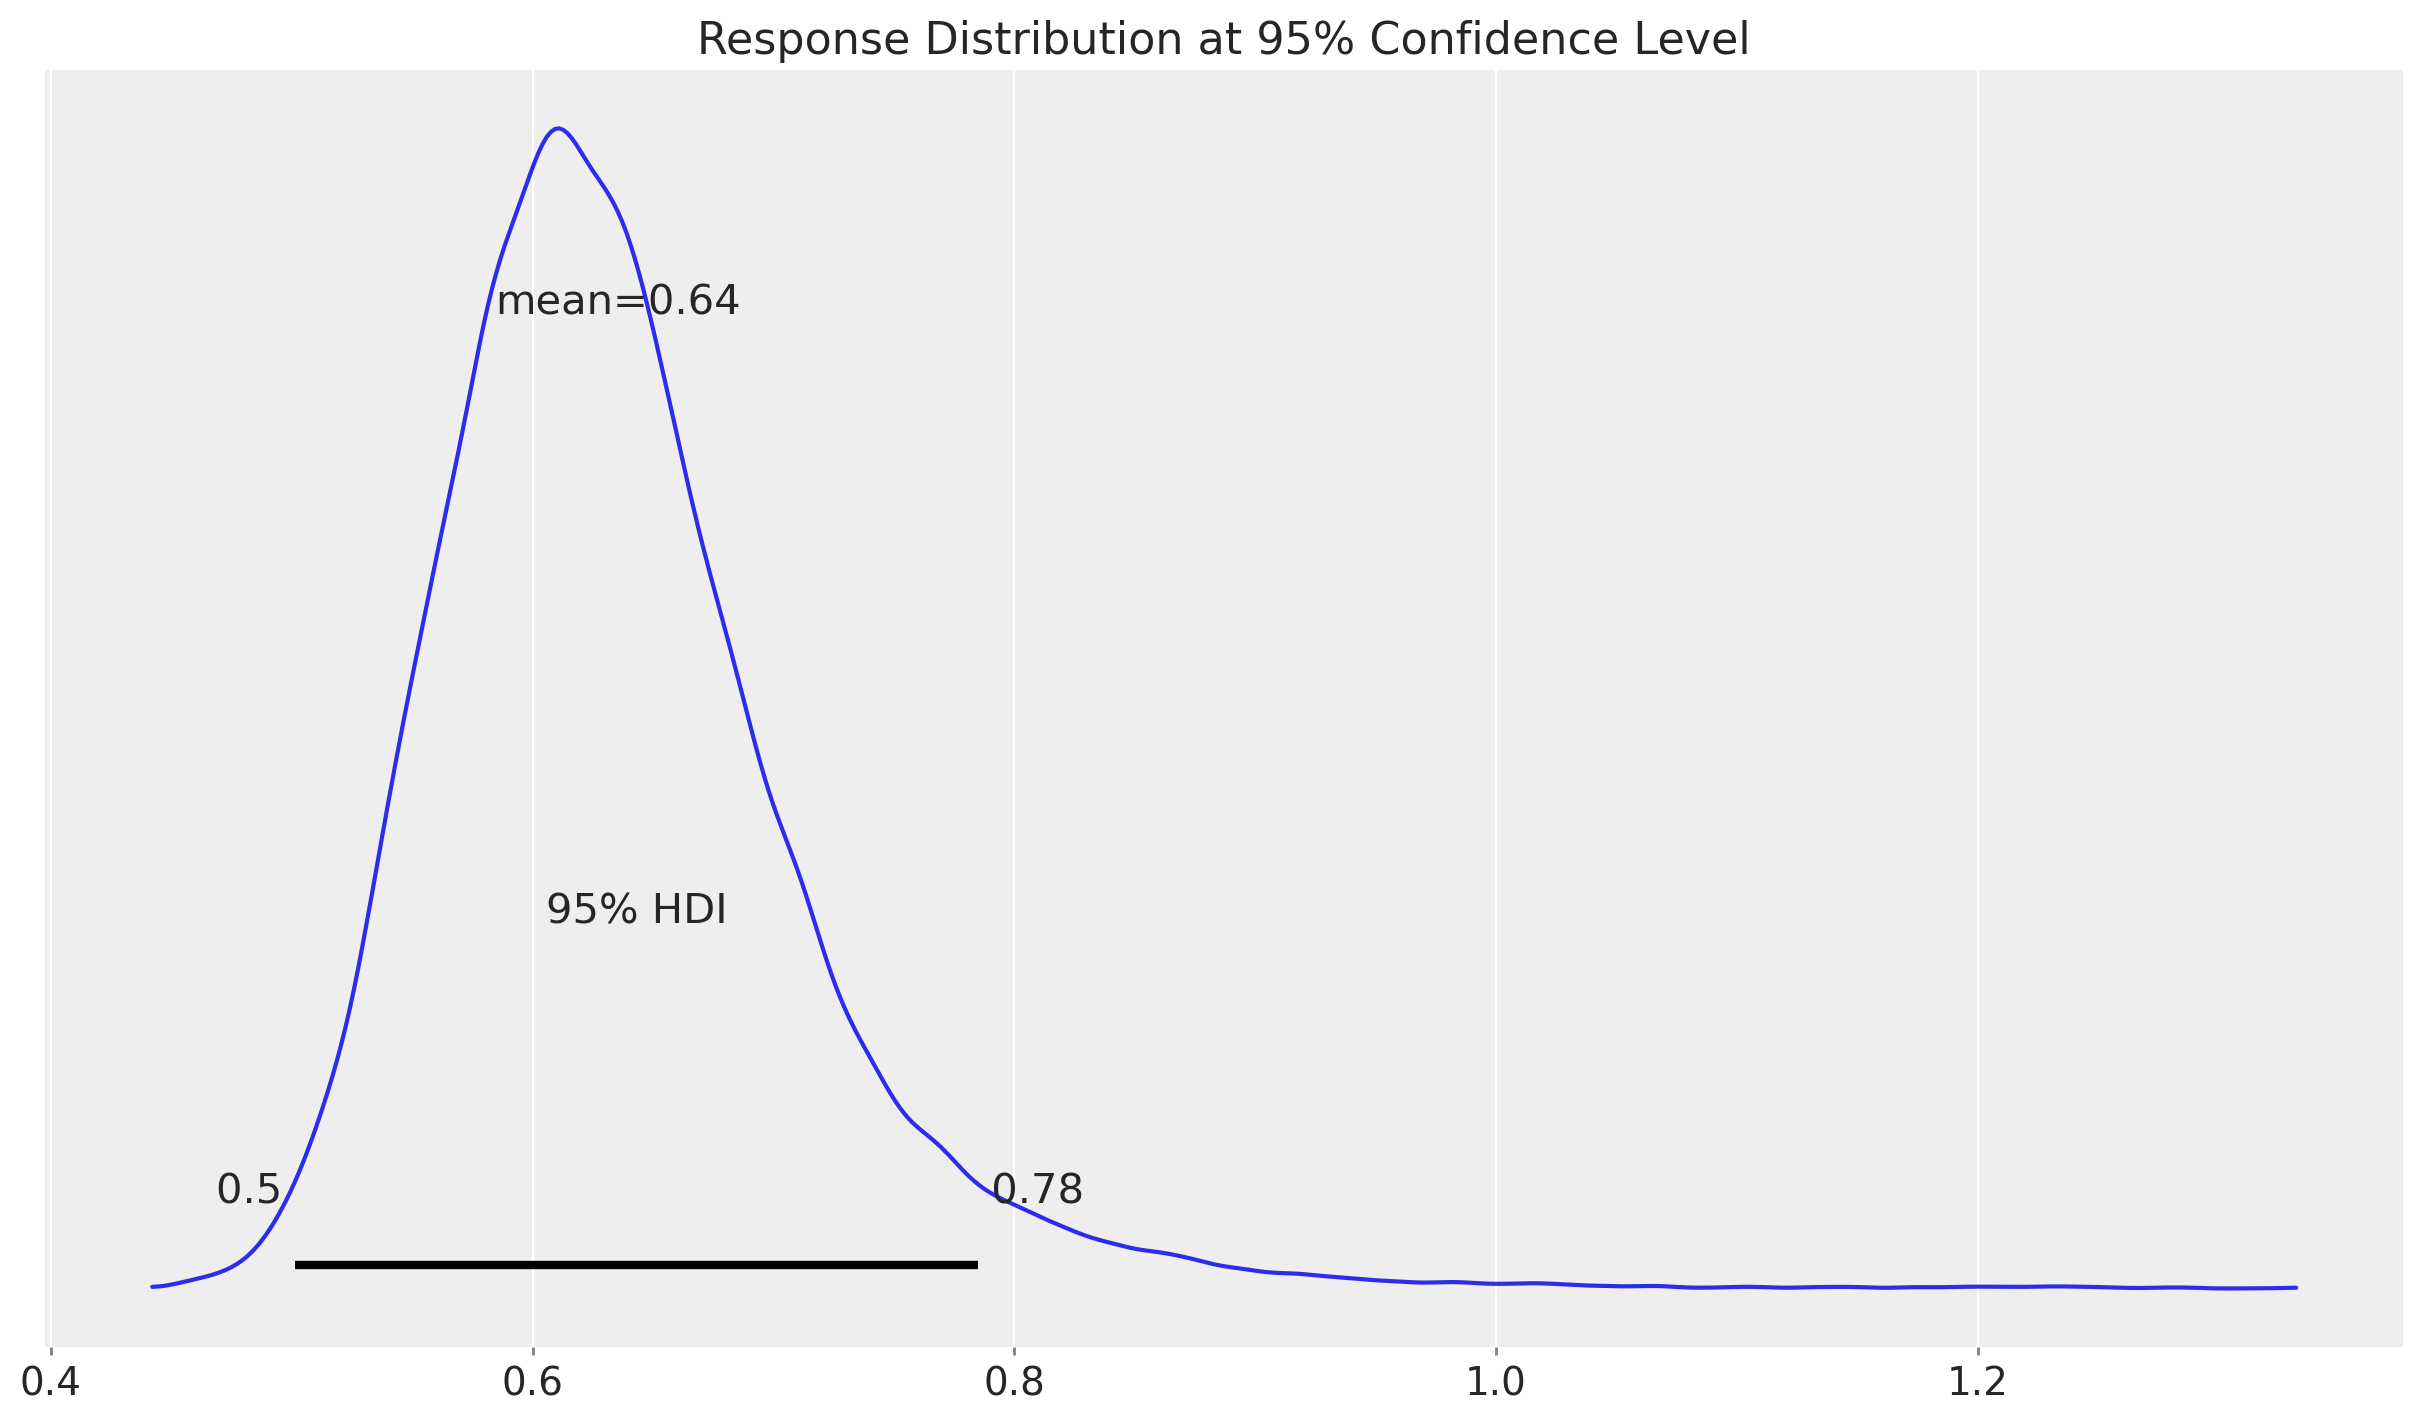

In [10]:
# Plot the response distribution by Arviz
az.plot_posterior(response_considering_risk.y.values.flatten(), hdi_prob=0.95)
plt.title("Response Distribution at 95% Confidence Level");

As expected, the distribution has bigger tails now.

## Optimizing Budget Allocation with Adjusted Value at Risk (aVaR)
We can also use the adjusted value at risk (aVaR) as our objective function. This criterion takes into account both the expected return and the risk tolerance of the investor. In this case, we're using a confidence level of 0.75, and a risk aversion parameter of 0.5. This means that we're willing to accept a 25% chance of losing more than the VaR, and we're moderately risk averse.

$$
AVaR\ Score = (1 - \alpha) \cdot \mu + \alpha \cdot VaR
$$

Where $\mu$ is the mean of the response, $VaR$ is the value at risk, and $\alpha$ is the risk aversion parameter. When $\alpha = 0$, we move towards the value at risk, and when $\alpha = 1$, we move towards the mean of the response.



Sampling: [y]


Output()

Budget allocation: {'x1': 2.999361060047214, 'x2': 2.000638939952786}
Total Allocated Budget: 5.0M


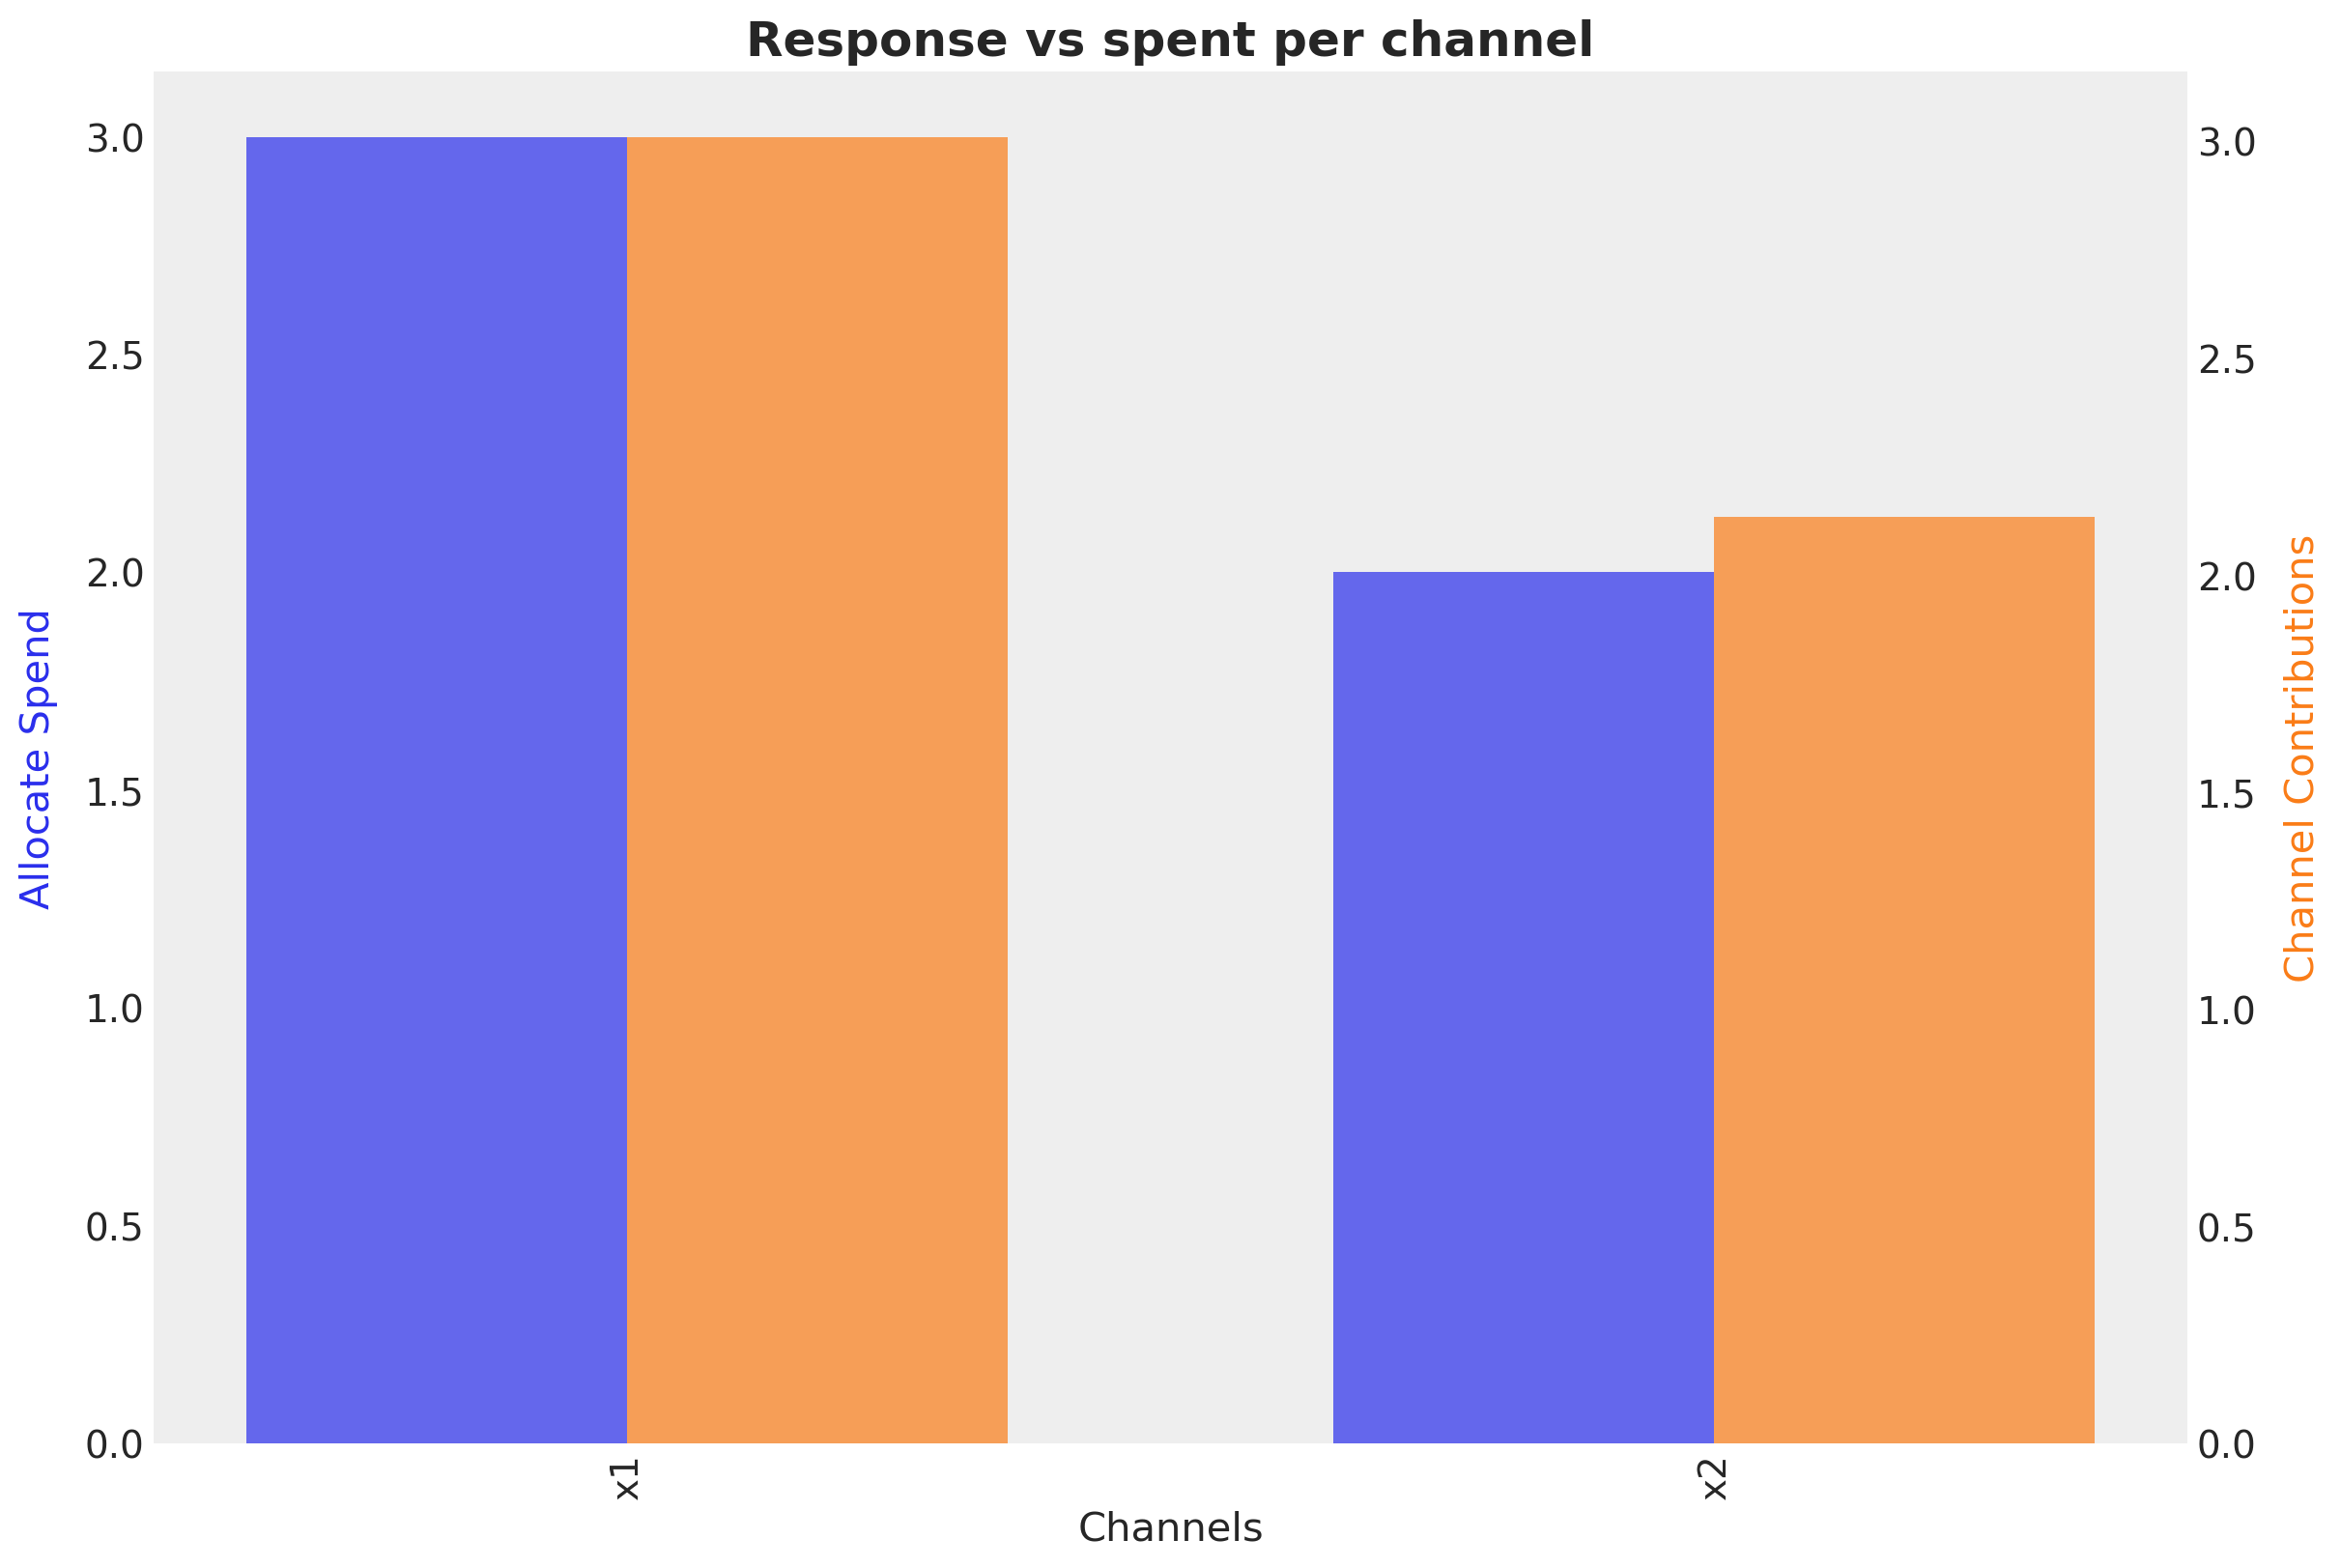

In [31]:
response_considering_risk = mmm.allocate_budget_to_maximize_response(
    budget=time_unit_budget,
    num_periods=num_periods,
    time_granularity="weekly",
    objective_function=RiskAssessment.adjusted_value_at_risk_score,
    objective_function_kwargs={"confidence_level": 0.75, "risk_aversion": 0.5},
)

print(f"Budget allocation: {mmm.optimal_allocation_dict}")
print(f"Total Allocated Budget: {np.sum(list(mmm.optimal_allocation_dict.values()))}M")

fig, ax = mmm.plot_budget_allocation(samples=response_considering_risk, figsize=(12, 8))
ax.set_title("Response vs spent per channel", fontsize=18, fontweight="bold");

We can see that the optimizer is allocating the budget to $X1$ again, but this time because our risk aversion parameter is 0.5, meaning moderately risk averse, the optimizer is allocating less budget to $X1$ than the simple VaR. Because he is looking to the trade-off between the expected return and the risk.

## Custom Risk Assessment Criterion
We can create our own risk assessment criterion by defining a function that takes the samples and the assets as inputs, and returns a scalar value that we want to optimize. In this case, we want to maximize the value at risk, considering the diversification ratio. 

We want to prefer the allocation that has the lowest value at risk, but with a high diversification between the marketing channels. Because we already understand how value at risk works, let's focus on the portafolio entropy.


In [29]:
RiskAssessment.portfolio_entropy(np.array([1,9])), RiskAssessment.portfolio_entropy(np.array([5,5]))

(0.3250829733914482, 0.6931471805599453)

We can see that the portfolio entropy is higher when the budget is allocated evenly, meaning that the risk is lower. 

Now, we can create our own risk assessment criterion by combining the value at risk and the portfolio entropy. In this case, we'll compute the value at risk and will multiply the response by the entropy in the portafolio. This will moderate the value at risk, and we'll prefer the allocation that has the lowest value at risk, but with a high diversification between the marketing channels.

In [24]:
def var_with_diversification(samples, assets, confidence_level):
    return RiskAssessment.value_at_risk(samples, confidence_level) * RiskAssessment.portfolio_entropy(assets)


Sampling: [y]


Output()

Budget allocation: {'x1': 2.5562819813313156, 'x2': 2.4437180186686844}
Total Allocated Budget: 5.0M


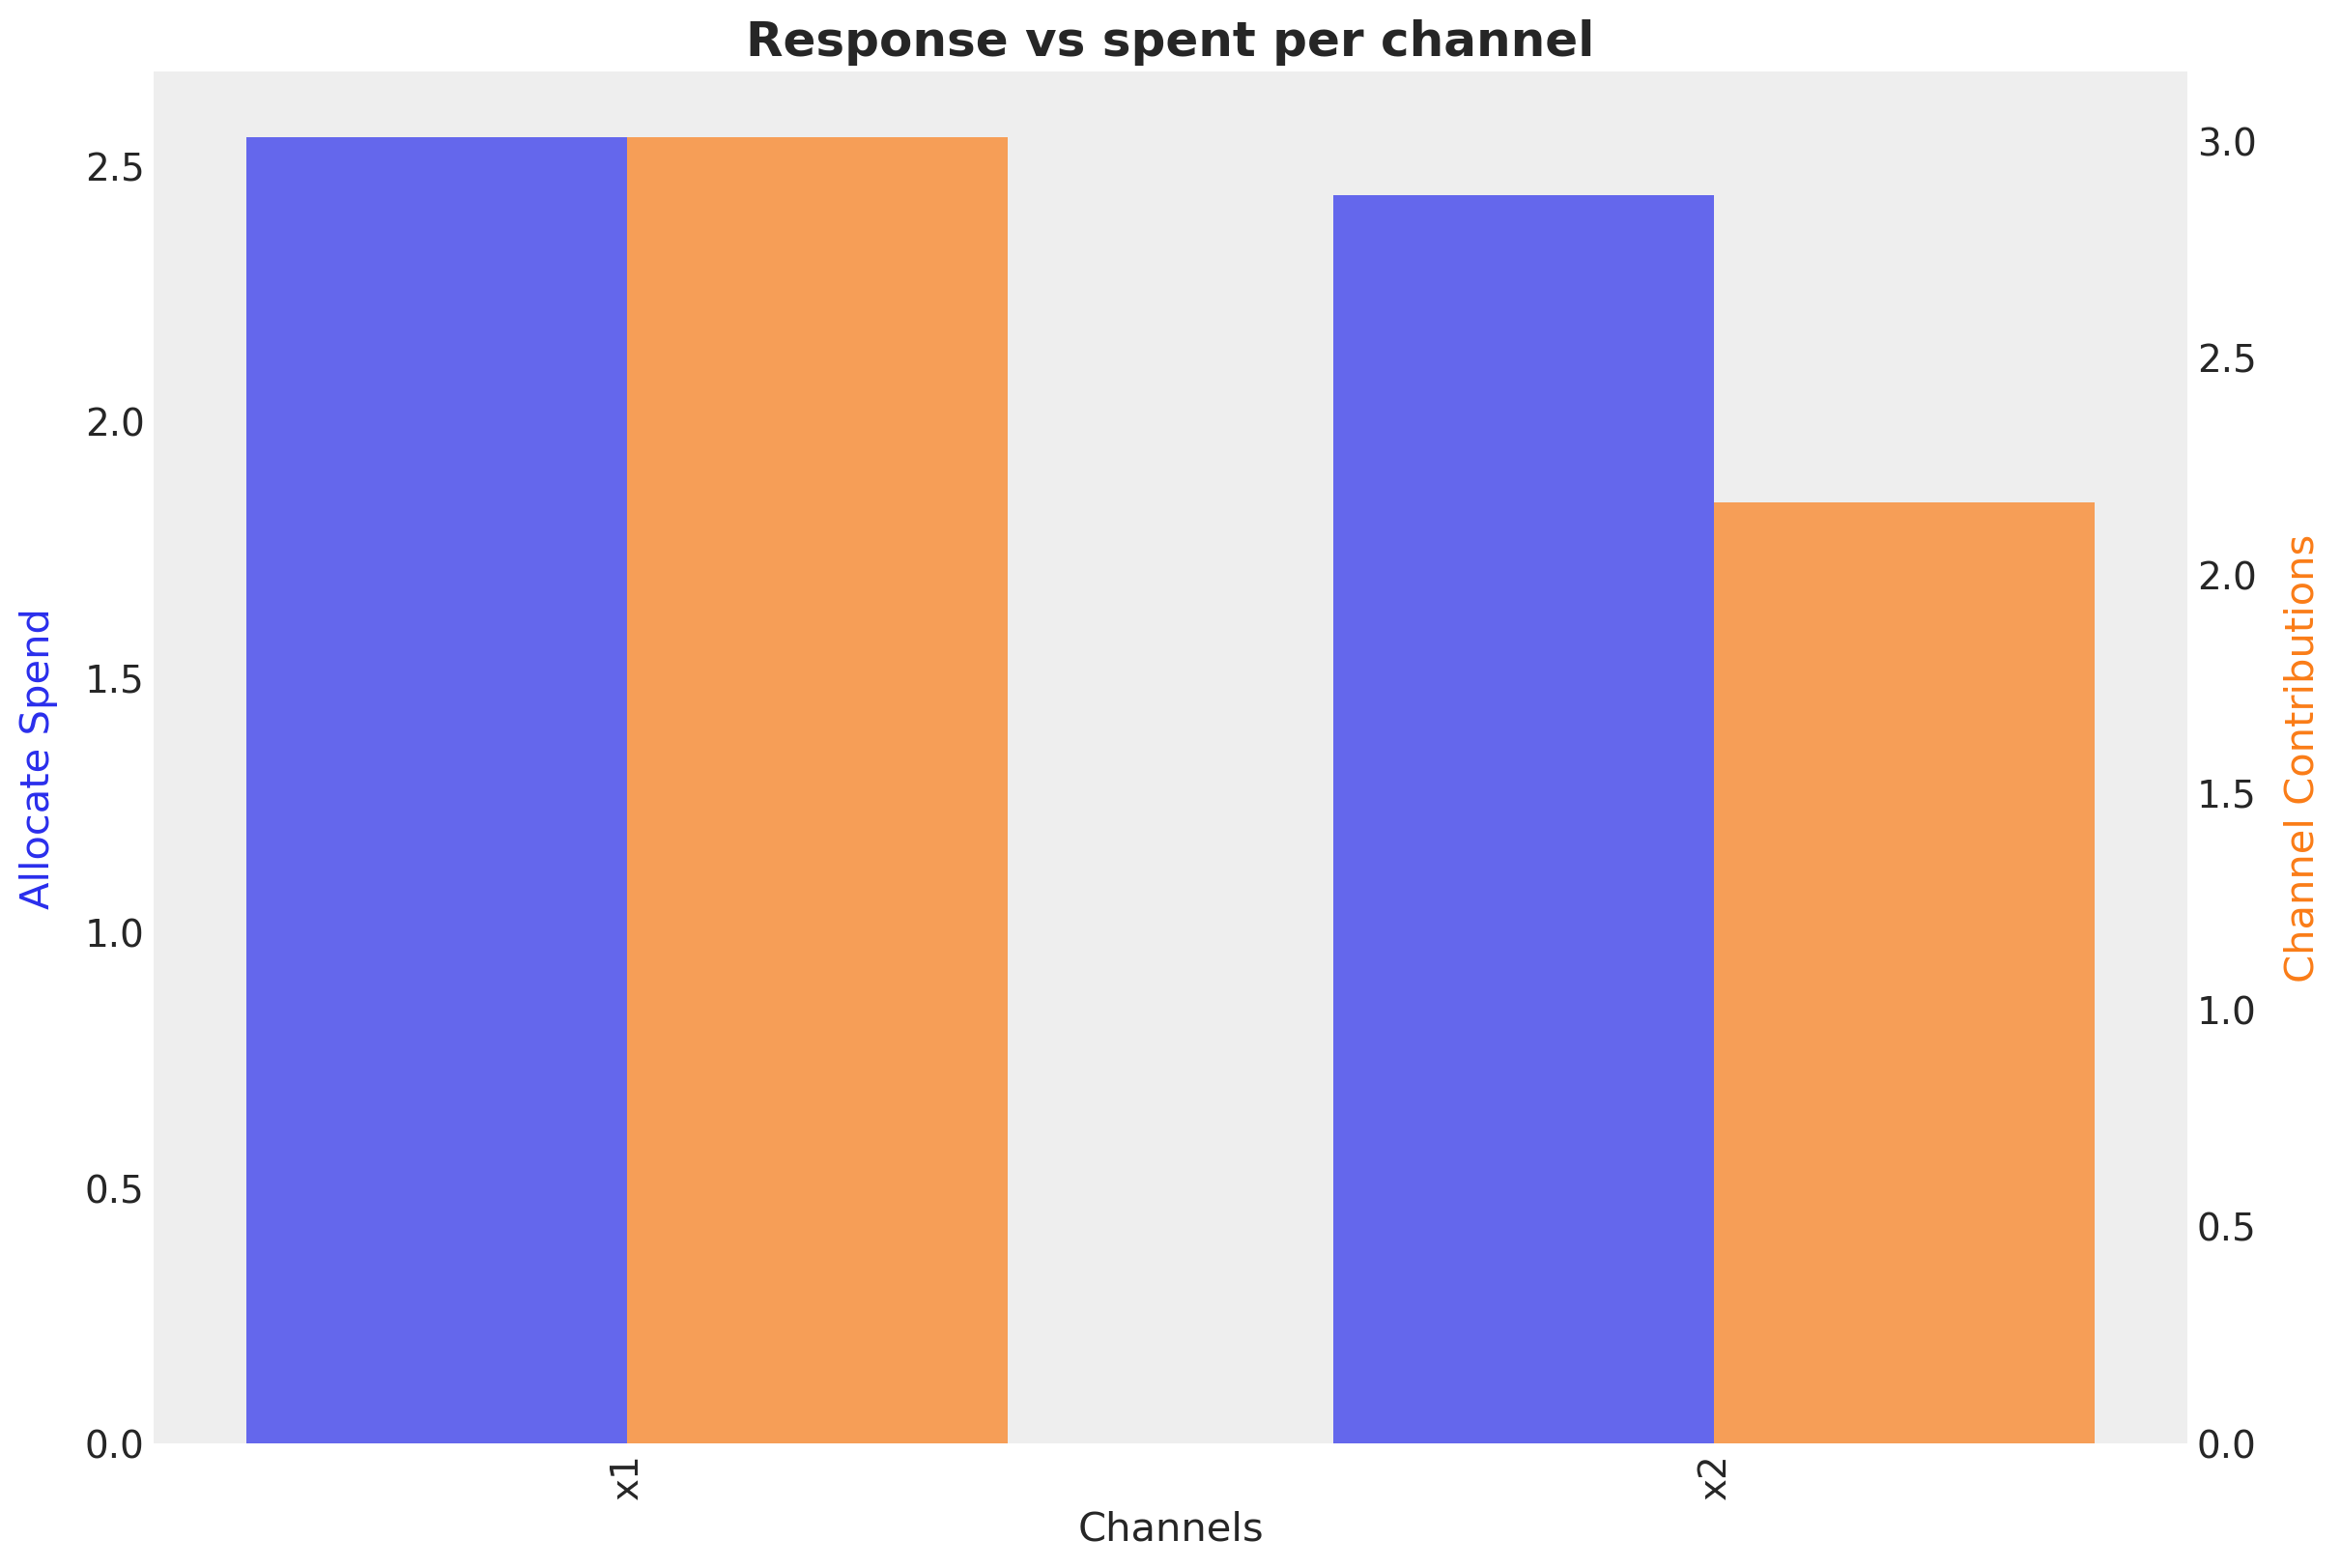

In [25]:
response_considering_risk = mmm.allocate_budget_to_maximize_response(
    budget=time_unit_budget,
    num_periods=num_periods,
    time_granularity="weekly",
    objective_function=lambda samples, assets: var_with_diversification(samples, assets, 0.95),
)

print(f"Budget allocation: {mmm.optimal_allocation_dict}")
print(f"Total Allocated Budget: {np.sum(list(mmm.optimal_allocation_dict.values()))}M")

fig, ax = mmm.plot_budget_allocation(samples=response_considering_risk, figsize=(12, 8))
ax.set_title("Response vs spent per channel", fontsize=18, fontweight="bold");

We can see that the optimizer is allocating the budget more evenly between the two channels. $X1$ has an allocation of 2.55M, and $X2$ has an allocation of 2.45M. This allocation is more balanced than the previous ones. Nevertheless, the total allocated budget is more balanced, the risk is higher, in response terms.

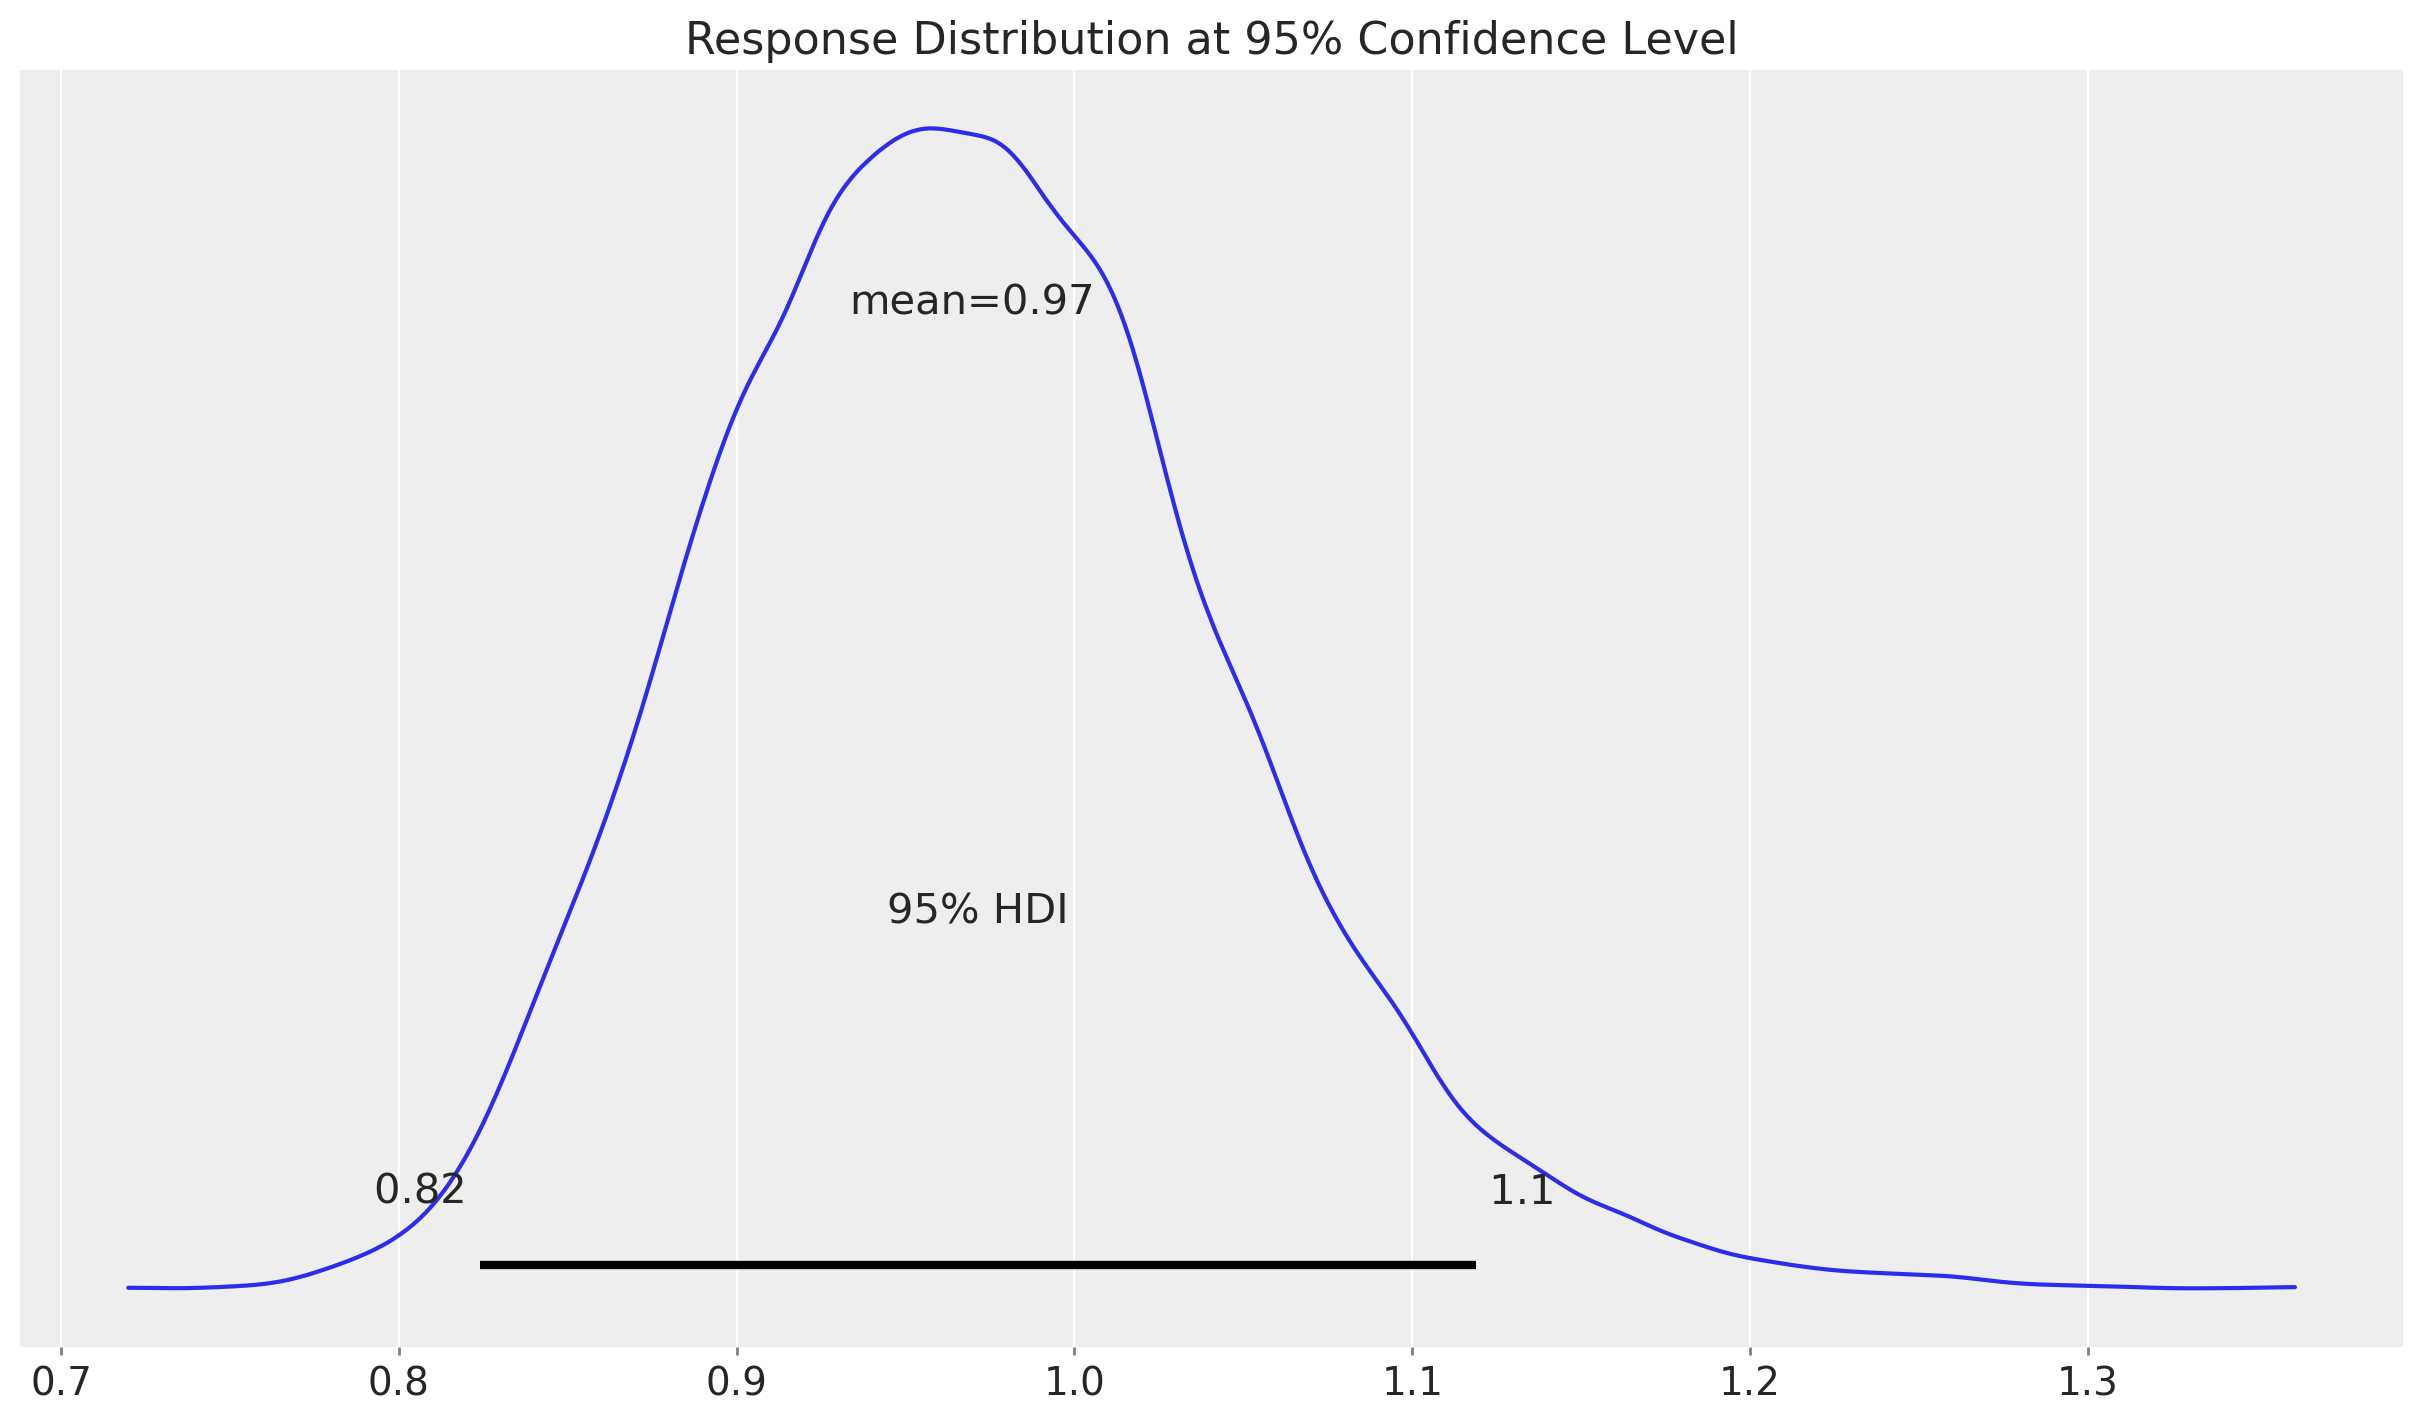

In [21]:
# Plot the response distribution by Arviz
az.plot_posterior(response_considering_risk.y.values.flatten(), hdi_prob=0.95)
plt.title("Response Distribution at 95% Confidence Level");

## Conclusion
In this notebook, we have seen how to assess the risk associated with different budget allocations, based on different strategies, and how to generate a budget allocation that is optimal under a risk tolerance criterion. We have used three different risk assessment criteria: Value at Risk (VaR), Adjusted Value at Risk (aVaR), and a custom criterion that takes into account both the value at risk and the diversification ratio.

Now it's your turn to create your own risk assessment criterion, and use it to optimize your budget allocation.

In [32]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sat Nov 02 2024

Python implementation: CPython
Python version       : 3.10.15
IPython version      : 8.29.0

pytensor: None

pymc_marketing: 0.10.0
arviz         : 0.20.0
pandas        : 2.2.3
numpy         : 1.26.4
matplotlib    : 3.9.2

Watermark: 2.5.0

